# Exploration of the Ford-go bike share system for February 2019
## by Christine Shuttleworth

## Preliminary Wrangling

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. The data comprises all data points for February 2019.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime as dt
import math
from geopy import Point
from geopy.distance import distance
import gmplot 
from scipy import stats
from scipy.stats import pearsonr

%matplotlib inline

pd.options.display.max_rows=100

df_bike_raw = pd.read_csv('./Data/201902-fordgobike-tripdata.csv')

base_color = sb.color_palette()[1]
line_color = sb.color_palette()[0]

### Assessing data and cleaning data

In [2]:
df_bike_raw.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [3]:
df_bike_raw.shape

(183412, 16)

In [4]:
df_bike_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [5]:
type(df_bike_raw.start_time[0])

str

In [6]:
df_bike_raw.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000


In [7]:
print(df_bike_raw.user_type.unique())
print(df_bike_raw.member_gender.unique())
print(df_bike_raw.bike_share_for_all_trip.unique())

['Customer' 'Subscriber']
['Male' nan 'Other' 'Female']
['No' 'Yes']


#### Assessment: 
The data table is set up as a clean data table. No variables are stored incorrectly or twice.
- Issue: Time is stored as sec, which is harder to interpret. Will change to minutes.
- Issue: Missing data points in the station_name and station_id. Lat and Long are given. Investigate if these points can be filled in from other information.
- Issue: start_time and end_time are str format -> convert to dateimt
- Issue: Station id should be an integer
- Issue: User Type and Member gender should be categorical
- Issue: Member birth year should be a datetime (year) or a string (will try year first)
- Issue: Bikeshare for all trip should be Boolean
- Issue: Bike ID could be a string

- Issue: max longitude is quite a way outside San Franzisco - need to plot outliers
- Issue: min longitude is in San Jose. Is this still in the greater San Franzikso bay area?
- Issue: max duraction_sec is about 23 hours - check value
- Issue: min duration_sec is about 1 min - check value
- Issue: min member_birth_year = 1878 - check values

#### Cleaning

In [8]:
## Issue: Missing data points in the station_name and station_id. Lat and Long are given. Investigate if these points can be filled in from other information.

df_nan_stations = df_bike_raw.loc[df_bike_raw.start_station_id.isnull()]
nan_stations = df_nan_stations.groupby(['start_station_latitude','start_station_longitude']).size().reset_index(name='station_count')

#for i in range(0,nan_stations.shape[0]):
#   print(df_bike_raw.query(f'start_station_latitude ==  {nan_stations.start_station_latitude[i]} and start_station_longitude == {nan_stations.start_station_longitude[i]}').start_station_name)
    
## None of th stations have station_id or station_name. So the data was not missed when inputing, it just does not exists for these stations.

In [9]:
# Issue: start_time and end_time are str format
# Issue: Member birth year should be a year 
df_bike_raw['start_time'] =  pd.to_datetime(df_bike_raw['start_time'])
df_bike_raw['end_time'] = pd.to_datetime(df_bike_raw['end_time'])
df_bike_raw['duration'] = df_bike_raw['end_time'] - df_bike_raw['start_time']
                                     
df_bike_raw['member_birth_year'] = pd.to_datetime(df_bike_raw['member_birth_year'], format='%Y')
df_bike_raw.head()
#df_bike.info()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984-01-01,Male,No,14:29:45.830000
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaT,NaN,No,11:48:41.267000
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972-01-01,Male,No,17:10:54.928000
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989-01-01,Other,No,10:08:10.832000
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974-01-01,Male,Yes,00:26:25.525000


In [10]:
# Issue: Station id should be an integer
# Issue: User Type and Member gender should be categorical
# Issue: Member birth year should be a year
# Issue: Bikeshare for all trip should be Boolean
# Issue: Bike ID could be a string
# There is no station_id that is 0, therefore 0 is used for missing data values

df_bike_raw.start_station_id.fillna(value=0, inplace=True) 
df_bike_raw.end_station_id.fillna(value=0, inplace=True)

df_bike_raw = df_bike_raw.astype({'start_station_id':'int64', 'end_station_id':'int64', 'bike_id':'str','member_gender':'category', 'user_type':'category'})

In [11]:
df_bike_raw['bike_share_for_all_trip'] = df_bike_raw.bike_share_for_all_trip.replace({'Yes': True,'No': False })

In [12]:
df_bike_raw.info()
df_bike_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   duration_sec             183412 non-null  int64          
 1   start_time               183412 non-null  datetime64[ns] 
 2   end_time                 183412 non-null  datetime64[ns] 
 3   start_station_id         183412 non-null  int64          
 4   start_station_name       183215 non-null  object         
 5   start_station_latitude   183412 non-null  float64        
 6   start_station_longitude  183412 non-null  float64        
 7   end_station_id           183412 non-null  int64          
 8   end_station_name         183215 non-null  object         
 9   end_station_latitude     183412 non-null  float64        
 10  end_station_longitude    183412 non-null  float64        
 11  bike_id                  183412 non-null  object         
 12  us

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984-01-01,Male,False,14:29:45.830000
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23,The Embarcadero at Steuart St,37.791464,-122.391034,81,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaT,NaN,False,11:48:41.267000
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972-01-01,Male,False,17:10:54.928000
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989-01-01,Other,False,10:08:10.832000
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974-01-01,Male,True,00:26:25.525000


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
92,1940,2019-02-28 22:42:29.789,2019-02-28 23:14:50.351,377,Fell St at Stanyan St,37.771917,-122.453704,50,2nd St at Townsend St,37.780526,-122.390288,4424,Subscriber,1987-01-01,Female,False,00:32:20.562000
196,1520,2019-02-28 22:10:44.680,2019-02-28 22:36:05.108,377,Fell St at Stanyan St,37.771917,-122.453704,126,Esprit Park,37.761634,-122.390648,5229,Subscriber,1987-01-01,Male,False,00:25:20.428000
771,847,2019-02-28 20:19:56.880,2019-02-28 20:34:04.433,377,Fell St at Stanyan St,37.771917,-122.453704,58,Market St at 10th St,37.776619,-122.417385,5867,Subscriber,1999-01-01,Male,False,00:14:07.553000
1228,244,2019-02-28 19:32:25.055,2019-02-28 19:36:29.607,377,Fell St at Stanyan St,37.771917,-122.453704,70,Central Ave at Fell St,37.773311,-122.444293,4407,Subscriber,1986-01-01,Male,False,00:04:04.552000
1451,1378,2019-02-28 18:52:01.967,2019-02-28 19:14:59.970,377,Fell St at Stanyan St,37.771917,-122.453704,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,5133,Subscriber,1984-01-01,Female,False,00:22:58.003000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182645,1453,2019-02-01 07:44:18.191,2019-02-01 08:08:31.606,377,Fell St at Stanyan St,37.771917,-122.453704,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,5315,Subscriber,NaT,NaN,False,00:24:13.415000
182726,648,2019-02-01 07:50:42.229,2019-02-01 08:01:30.845,377,Fell St at Stanyan St,37.771917,-122.453704,56,Koshland Park,37.773414,-122.427317,5063,Subscriber,1985-01-01,Female,False,00:10:48.616000
182838,1634,2019-02-01 07:24:08.481,2019-02-01 07:51:22.662,377,Fell St at Stanyan St,37.771917,-122.453704,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,1228,Subscriber,1983-01-01,Male,False,00:27:14.181000
182980,953,2019-02-01 07:17:38.537,2019-02-01 07:33:32.186,377,Fell St at Stanyan St,37.771917,-122.453704,110,17th & Folsom Street Park (17th St at Folsom St),37.763708,-122.415204,4597,Subscriber,1990-01-01,Female,False,00:15:53.649000


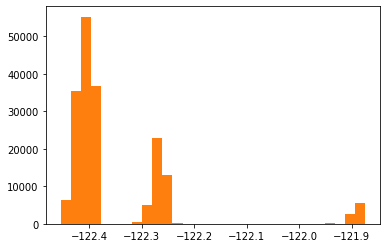

In [13]:
## Issue: max longitude is quite a way outside San Franzisco - need to plot outliers
## Issue: min longitude is in San Jose. Is this still in the greater San Franzikso bay area?
plt.hist(data=df_bike_raw, x = 'start_station_longitude', color = base_color, bins=30);
df_bike_raw.loc[df_bike_raw.start_station_longitude == df_bike_raw.start_station_longitude.max()]

## I think these points are valid points and belong to the greater San Francisco area. There is no mistake here.

df_bike_raw.loc[df_bike_raw.start_station_longitude == df_bike_raw.start_station_longitude.min()]

## The min is bang in the middle of San Francisco. Also no mistake.

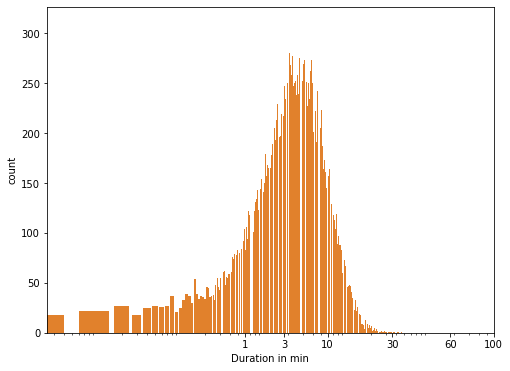

In [14]:
## Issue: max duraction_sec is about 23 hours - check value
## Issue: min duration_sec is about 1 min - check value
plt.figure(figsize=[8,6])

duration_ticks = [60, 180, 600, 3600, 18000, 60000]
duration_labels = [1,3,10,30,60,100]

g = sb.countplot(data=df_bike_raw, x='duration_sec', color=base_color)
g.set_xscale("log")
plt.xticks(duration_ticks,duration_labels);
plt.xlabel('Duration in min');

In [15]:
df_bike_raw.loc[df_bike_raw.duration_sec == df_bike_raw.duration_sec.max()]
df_bike_raw.loc[df_bike_raw.duration_sec == df_bike_raw.duration_sec.min()]

#df_bike.loc[df_bike.duration_sec > 80000]
###The min and max values are possible and have been recorded as such. There are no errors here but quite a few outliers.

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
18578,61,2019-02-26 18:23:44.283,2019-02-26 18:24:45.523,368,Myrtle St at Polk St,37.785434,-122.419622,368,Myrtle St at Polk St,37.785434,-122.419622,5333,Subscriber,1989-01-01,Female,False,00:01:01.240000
19581,61,2019-02-26 16:40:53.121,2019-02-26 16:41:54.451,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,5306,Subscriber,1987-01-01,Female,False,00:01:01.330000
27017,61,2019-02-25 10:31:18.415,2019-02-25 10:32:19.748,59,S Van Ness Ave at Market St,37.774814,-122.418954,59,S Van Ness Ave at Market St,37.774814,-122.418954,5921,Subscriber,1972-01-01,Male,True,00:01:01.333000
44301,61,2019-02-22 15:09:57.048,2019-02-22 15:10:58.742,310,San Fernando St at 4th St,37.335885,-121.885660,280,San Fernando St at 7th St,37.337122,-121.883215,6347,Subscriber,1989-01-01,Male,True,00:01:01.694000
44787,61,2019-02-22 13:56:21.976,2019-02-22 13:57:23.465,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,81,Berry St at 4th St,37.775880,-122.393170,6150,Subscriber,1931-01-01,Male,False,00:01:01.489000
51120,61,2019-02-21 18:27:34.993,2019-02-21 18:28:36.630,113,Franklin Square,37.764555,-122.410345,100,Bryant St at 15th St,37.767100,-122.410662,6515,Subscriber,1984-01-01,Male,False,00:01:01.637000
58992,61,2019-02-20 21:44:00.154,2019-02-20 21:45:01.235,85,Church St at Duboce Ave,37.770083,-122.429156,85,Church St at Duboce Ave,37.770083,-122.429156,4351,Subscriber,1994-01-01,Male,False,00:01:01.081000
64088,61,2019-02-20 13:08:18.285,2019-02-20 13:09:19.433,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,80,Townsend St at 5th St,37.775235,-122.397437,2090,Subscriber,1931-01-01,Male,False,00:01:01.148000
80047,61,2019-02-18 16:31:12.896,2019-02-18 16:32:14.588,89,Division St at Potrero Ave,37.769218,-122.407646,101,15th St at Potrero Ave,37.767079,-122.407359,6195,Subscriber,1931-01-01,Male,False,00:01:01.692000
82564,61,2019-02-18 09:53:31.399,2019-02-18 09:54:33.162,249,Russell St at College Ave,37.858473,-122.253253,249,Russell St at College Ave,37.858473,-122.253253,3054,Subscriber,1990-01-01,Male,False,00:01:01.763000


In [16]:
## Issue: min member_birth_year = 1878 - check values

df_bike_raw.loc[df_bike_raw.member_birth_year == df_bike_raw.member_birth_year.min()]

#This is certainly an error. I will update the dataframe to set the birthyear to 1978, which is much more likely.
df_bike_raw['member_birth_year'] = df_bike_raw['member_birth_year'].mask(df_bike_raw['member_birth_year'].dt.year < 1900, 
                             df_bike_raw['member_birth_year'] + pd.offsets.DateOffset(years=100))

df_bike_raw.loc[df_bike_raw.member_birth_year == df_bike_raw.member_birth_year.min()]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
1285,148,2019-02-28 19:29:17.627,2019-02-28 19:31:45.967,158,Shattuck Ave at Telegraph Ave,37.833279,-122.263490,173,Shattuck Ave at 55th St,37.840364,-122.264488,5391,Subscriber,1900-01-01,Male,True,00:02:28.340000
10827,1315,2019-02-27 19:21:34.436,2019-02-27 19:43:30.008,343,Bryant St at 2nd St,37.783172,-122.393572,375,Grove St at Masonic Ave,37.774836,-122.446546,6249,Subscriber,1900-01-01,Male,False,00:21:55.572000
16087,1131,2019-02-27 08:37:36.864,2019-02-27 08:56:28.022,375,Grove St at Masonic Ave,37.774836,-122.446546,36,Folsom St at 3rd St,37.783830,-122.398870,4968,Subscriber,1900-01-01,Male,False,00:18:51.158000
19375,641,2019-02-26 17:03:19.855,2019-02-26 17:14:01.619,9,Broadway at Battery St,37.798572,-122.400869,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,6164,Customer,1900-01-01,Male,False,00:10:41.764000
21424,1424,2019-02-26 08:58:02.904,2019-02-26 09:21:47.749,375,Grove St at Masonic Ave,37.774836,-122.446546,343,Bryant St at 2nd St,37.783172,-122.393572,5344,Subscriber,1900-01-01,Male,False,00:23:44.845000
21506,701,2019-02-26 09:06:11.239,2019-02-26 09:17:52.442,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,9,Broadway at Battery St,37.798572,-122.400869,5337,Customer,1900-01-01,Male,False,00:11:41.203000
24042,194,2019-02-25 18:58:10.644,2019-02-25 19:01:25.308,158,Shattuck Ave at Telegraph Ave,37.833279,-122.263490,173,Shattuck Ave at 55th St,37.840364,-122.264488,6363,Subscriber,1900-01-01,Male,True,00:03:14.664000
26133,410,2019-02-25 13:38:12.067,2019-02-25 13:45:02.207,173,Shattuck Ave at 55th St,37.840364,-122.264488,176,MacArthur BART Station,37.828410,-122.266315,3311,Subscriber,1900-01-01,Male,True,00:06:50.140000
27675,1087,2019-02-25 09:10:39.549,2019-02-25 09:28:46.676,375,Grove St at Masonic Ave,37.774836,-122.446546,36,Folsom St at 3rd St,37.783830,-122.398870,5250,Subscriber,1900-01-01,Male,False,00:18:07.127000
32285,299,2019-02-24 14:48:50.554,2019-02-24 14:53:50.330,179,Telegraph Ave at 27th St,37.816073,-122.267886,195,Bay Pl at Vernon St,37.812314,-122.260779,2339,Subscriber,1900-01-01,Female,False,00:04:59.776000


/Users/cshuttleworth/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


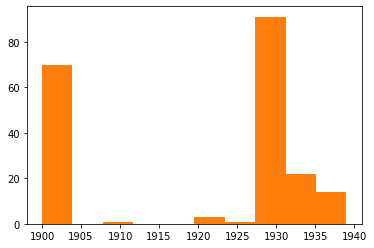

In [17]:
#plt.hist(data=df_bike, x='member_birth_year', bins=20);

## There is another spike around 1900. These birthdays were probably put in wrong. The users may not have wanted to give the birthday or they
## meant to select 2000. 

plt.hist (data=df_bike_raw.query('member_birth_year < 1940'), x='member_birth_year', color=base_color);

## I will set birthdays below 1920 to Null values. As they are most likely wrongly input. Not sure how many 100 year old are still cycling in San Francisco!

df_bike_raw['member_birth_year'].loc[df_bike_raw['member_birth_year'].dt.year <= 1920] = np.nan

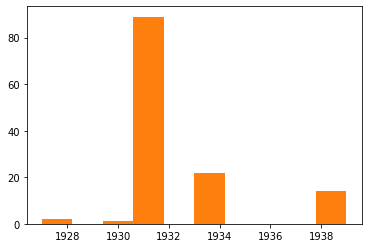

In [18]:
plt.hist (data=df_bike_raw.query('member_birth_year < 1940'), x='member_birth_year', color=base_color);

In [19]:
df_bike_raw.query('member_birth_year < 1930')

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration
35746,568,2019-02-23 17:46:46.163,2019-02-23 17:56:14.975,85,Church St at Duboce Ave,37.770083,-122.429156,100,Bryant St at 15th St,37.76710,-122.410662,6294,Customer,1928-01-01,Other,False,00:09:28.812000
183388,490,2019-02-01 00:39:53.112,2019-02-01 00:48:03.338,61,Howard St at 8th St,37.776513,-122.411306,81,Berry St at 4th St,37.77588,-122.393170,5411,Subscriber,1927-01-01,Male,False,00:08:10.226000


### Adding extra column: Distance_km

The dataset has been cleaned. Now I would like to add another column that contains the distance between the start_station and the end_station. Having the starting Lat/Long and End Lat/Long, I can calculate this.

In [20]:
##Creating two new columns with geopy that depict the start and end point of the journey

df_bike_raw['start_point'] = df_bike_raw.apply(lambda row: Point(latitude=row['start_station_latitude'], longitude=row['start_station_longitude']), axis=1)
df_bike_raw['end_point'] = df_bike_raw.apply(lambda row: Point(latitude=row['end_station_latitude'], longitude=row['end_station_longitude']), axis=1)

In [21]:
df_bike_raw.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration,start_point,end_point
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984-01-01,Male,False,14:29:45.830000,"37 47m 22.6514s N, 122 24m 2.9196s W","37 47m 39.2316s N, 122 24m 10.5228s W"
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23,The Embarcadero at Steuart St,37.791464,-122.391034,81,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaT,NaN,False,11:48:41.267000,"37 47m 29.2704s N, 122 23m 27.7224s W","37 46m 33.168s N, 122 23m 35.412s W"
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972-01-01,Male,False,17:10:54.928000,"37 46m 9.49908s N, 122 25m 36.5722s W","37 47m 10.951s N, 122 24m 17.6557s W"
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989-01-01,Other,False,10:08:10.832000,"37 46m 29.4107s N, 122 26m 47.5644s W","37 46m 23.9192s N, 122 26m 39.4534s W"
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974-01-01,Male,True,00:26:25.525000,"37 48m 16.4245s N, 122 16m 18.257s W","37 47m 33.7715s N, 122 14m 55.6066s W"


In [22]:
## Calculate the distance between the two points

df_bike_raw['distance_km'] = df_bike_raw.apply(lambda row: distance(row['start_point'], row['end_point']).km , axis=1)


In [23]:
df_bike_raw.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration,start_point,end_point,distance_km
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984-01-01,Male,False,14:29:45.830000,"37 47m 22.6514s N, 122 24m 2.9196s W","37 47m 39.2316s N, 122 24m 10.5228s W",0.543983
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23,The Embarcadero at Steuart St,37.791464,-122.391034,81,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaT,NaN,False,11:48:41.267000,"37 47m 29.2704s N, 122 23m 27.7224s W","37 46m 33.168s N, 122 23m 35.412s W",1.739909
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972-01-01,Male,False,17:10:54.928000,"37 46m 9.49908s N, 122 25m 36.5722s W","37 47m 10.951s N, 122 24m 17.6557s W",2.705390
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989-01-01,Other,False,10:08:10.832000,"37 46m 29.4107s N, 122 26m 47.5644s W","37 46m 23.9192s N, 122 26m 39.4534s W",0.260896
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974-01-01,Male,True,00:26:25.525000,"37 48m 16.4245s N, 122 16m 18.257s W","37 47m 33.7715s N, 122 14m 55.6066s W",2.412017


### Adding extra column: start_point_quadrant - NE, NW, SE, SW 

In [24]:
##Create lat and long bins to sort start station into and convert lat and long into a categorical value
median_lat = df_bike_raw.start_station_latitude.median()
lat_min = df_bike_raw.start_station_latitude.min()
lat_max = df_bike_raw.start_station_latitude.max()

bins_lat=[lat_min-1, median_lat, lat_max +1]
labels_lat = ['S', 'N']

median_long = df_bike_raw.start_station_longitude.median()
long_min = df_bike_raw.start_station_longitude.min()
long_max = df_bike_raw.start_station_longitude.max()
bins_long=[long_min-1,median_long, long_max+1]
labels_long = ['E', 'W']
          
start_point_quadrant_lat = pd.cut(df_bike_raw.start_station_latitude, bins_lat, labels=labels_lat, include_lowest=True)
start_point_quadrant_long = pd.cut(df_bike_raw.start_station_longitude, bins_long, labels=labels_long, include_lowest=True)    

#start_point_quadrant_lat

df_bike_raw['start_point_quadrant'] = start_point_quadrant_lat.astype(str) + start_point_quadrant_long.astype(str)

#mean_price = diamonds.groupby(carat_bins).price


In [25]:
print(median_lat)
print(median_long)

37.7807601
-122.3982846736908


### Adding extra column: end_point_quadrant - NE, NW, SE, SW

In [26]:
##Create lat and long bins to sort start station into and convert lat and long into a categorical value
median_lat = df_bike_raw.end_station_latitude.median()
lat_min = df_bike_raw.end_station_latitude.min()
lat_max = df_bike_raw.end_station_latitude.max()

bins_lat=[lat_min-1, median_lat, lat_max +1]
labels_lat = ['S', 'N']

median_long = df_bike_raw.end_station_longitude.median()
long_min = df_bike_raw.end_station_longitude.min()
long_max = df_bike_raw.end_station_longitude.max()

bins_long=[long_min-1,median_long, long_max+1]
labels_long = ['E', 'W']
          
end_point_quadrant_lat = pd.cut(df_bike_raw.end_station_latitude, bins_lat, labels=labels_lat, include_lowest=True)
end_point_quadrant_long = pd.cut(df_bike_raw.end_station_longitude, bins_long, labels=labels_long, include_lowest=True)    


df_bike_raw['end_point_quadrant'] = end_point_quadrant_lat.astype(str) + end_point_quadrant_long.astype(str)

## Need to refractor to create a funtion and read in column names


In [27]:
print(median_lat)
print(median_long)

37.78100971717512
-122.39827930927277


In [29]:
##does not work yet. I am keeping this for future reference
#import gmplot 
  
## GoogleMapPlotter return Map object 
## Pass the center latitude and 
## center longitude 
#gmap1 = gmplot.GoogleMapPlotter(median_lat, 
                               # median_long, 13) ##13 is the zoom

## Pass the absolute path 
#gmap1.draw( "/Users/cshuttleworth/Projects/Udacity_DAND_Project5_Visuals/median.png" )


![image](MedianPoint1.png)

In [30]:
df_bike_raw.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration,start_point,end_point,distance_km,start_point_quadrant,end_point_quadrant
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,...,Customer,1984-01-01,Male,False,14:29:45.830000,"37 47m 22.6514s N, 122 24m 2.9196s W","37 47m 39.2316s N, 122 24m 10.5228s W",0.543983,NE,NE
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23,The Embarcadero at Steuart St,37.791464,-122.391034,81,Berry St at 4th St,37.775880,...,Customer,NaT,NaN,False,11:48:41.267000,"37 47m 29.2704s N, 122 23m 27.7224s W","37 46m 33.168s N, 122 23m 35.412s W",1.739909,NW,SW


### What is the structure of your dataset?

The data consists of 20 variables and about 180 000 rows of data associated with the Ford bike share system in the Greater San Francisco area. The data includes:
- the start and end time of each trip, duration of the trip, 
- location of the start and end of the journey and the distance of the journey, 
- bike id and 
- information on the customer that used the bike. Ideally, there should be a separate customer table with the information of each user of the bike share system, but there is not enough information to create this. As it is, the users are kept anonymous. 
- Finally, there is data recording if the trip was completely covered by the bike share or if the distance cycled was only part of the trip.

This dataset contains some date_time variables, numeric variables, names, one boolean column and two categorical columns:

User Type:
- 'Customer'
- 'Subscriber'

Member Gender:
- 'Male'
- 'Female'
- 'Other'
- nan

### What is/are the main feature(s) of interest in your dataset?

My main interest is which variables predict the length in time of a bike share journey best. This is a useful variable to be able to predict, for forecasting the usage of the bike share system. My aim is going to be finding useful customer subgroups that use the bike share system differently. I will try and find subgroups based in the user information, geographical information and datetime information. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect the length and distance of the trip change with the different user characteristics, e.g. type of user, gender, age. The length and distance may also be influenced by the location of the start and end points of the trips and the day of the week when the trip took place.

Having two variables that describe the journey - length and distance - I can compare how well they describe each other. Are shorter journeys in time also shorter in distance? Maybe some of the audiences/user subgroups can be defined by the distance of the trips they take. 

The start_time and end_time column of the bike share journeys, helps the investigation, when in Feb 2019 are most trips taken. During the week or weekend? Do these trends vary for the different user characteristics?

The station information is interesting, as I can use this to find out which stations are used most often to start longer or shorter journeys. Are there areas in the Greater San Francisco area 
where longer bike trips are taken than others? Does the average distance of the trips vary with the location of the start of the trip/end of the trip? For this I will categorise the stations into quadrants - that divide the greater San Francisco area into four parts, NW, NE, SE, SW. The midpoint of the quadrant will be based on the median of the station latitude and the median of the station longitude, dividing the dataset into half E/W as well as N/S. Ideally, I would carry out a more detailed geographical investigation, but I do not have enough time to carry this out.

As part of the exploration, I will also look at variables that are not so closely linked to duration and distance of the trip, to get a better picture of the overall data.

## Univariate Exploration

In this section, I will look at the two main numerical variables of interests: trip length and distance. To be able to find what influences the length and distance of a trip, I will also look the the categorical columns of user_type, customer_gender, 

In [31]:
## copying cleaned dataset to a new dataframe

df_bike = df_bike_raw.copy()
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   duration_sec             183412 non-null  int64          
 1   start_time               183412 non-null  datetime64[ns] 
 2   end_time                 183412 non-null  datetime64[ns] 
 3   start_station_id         183412 non-null  int64          
 4   start_station_name       183215 non-null  object         
 5   start_station_latitude   183412 non-null  float64        
 6   start_station_longitude  183412 non-null  float64        
 7   end_station_id           183412 non-null  int64          
 8   end_station_name         183215 non-null  object         
 9   end_station_latitude     183412 non-null  float64        
 10  end_station_longitude    183412 non-null  float64        
 11  bike_id                  183412 non-null  object         
 12  us

In [32]:
df_bike.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,duration,distance_km
count,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412,183412.000000
mean,726.078435,138.441569,37.771223,-122.352664,136.102780,37.771427,-122.352250,0 days 00:12:06.577548,1.690555
std,1794.389780,111.811012,0.099581,0.117097,111.544544,0.099490,0.116673,0 days 00:29:54.388971,1.097158
min,61.000000,0.000000,37.317298,-122.453704,0.000000,37.317298,-122.453704,0 days 00:01:01.081000,0.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,0 days 00:05:25.428500,0.909777
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,0 days 00:08:34.649500,1.429907
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,0 days 00:13:16.317000,2.226169
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,0 days 23:44:04.830000,69.465977


### Bike trip duration:

In [33]:
np.log10(df_bike.duration_sec).describe()

count    183412.000000
mean          2.712606
std           0.309396
min           1.785330
25%           2.511883
50%           2.710963
75%           2.900913
max           4.931682
Name: duration_sec, dtype: float64

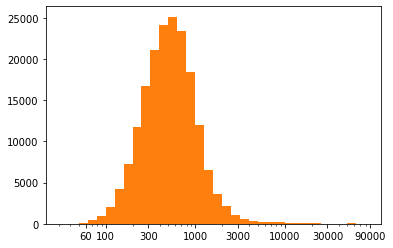

In [34]:
bins = 10 ** np.arange(1.5,5,0.1)
ticks = [60, 100, 300, 1000, 3000, 10000, 30000, 90000]

plt.hist(data=df_bike, x='duration_sec', bins=bins, color=base_color)
plt.xscale('log')
plt.xticks(ticks, ticks); #duration_ticks, durations_label

The distribution of the duration of the bike trips is unimodal with a spike around 500 seconds (8 min). The distribution is extremely skewed to the right with large outliers. 75 % of the trips are shorter than 13 mins. The longest trip was 23h44 min. It is unlikely that the trip on a bike within the San Francisco Bay area will take a whole day (max = 23h44min). I suspect the bike was rented and used for several trips or taken somewhere over night and returned it on the next day. I will keep these outliers in the data however, as the bike was unavailable for other users during this time. It does not matter if it was ridden or not. How much time was spend on the bike can be estimated, once I compare the distance with the trip length by e.g. calculating average speed. A low speed will indicate more time spend off the bike.

A box plot will give me an overview of the spread of the majority of the points, with probabilities how long a trip will take.

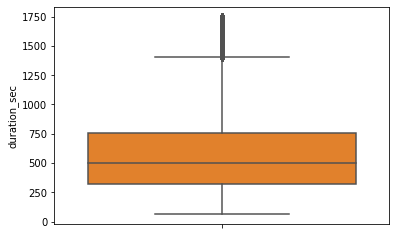

In [35]:
sb.boxplot(data=df_bike.query('duration_sec < 1750'), y='duration_sec', color=base_color);

###  Bike trip distance:

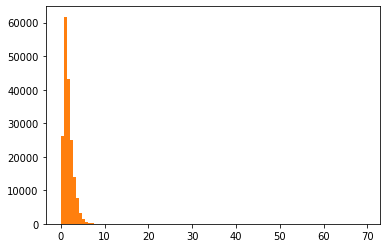

In [36]:
plt.hist(data=df_bike, x='distance_km', color=base_color, bins=100);

Just like the journey time, the distance is also very highly skewed to the right. I will add a log scale transformation to see the detail of the distribution of the shorter trips.

In [37]:
np.log10(df_bike.distance_km.describe())

/Users/cshuttleworth/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


count    5.263428
mean     0.228029
std      0.040269
min          -inf
25%     -0.041065
50%      0.155308
75%      0.347558
max      1.841772
Name: distance_km, dtype: float64

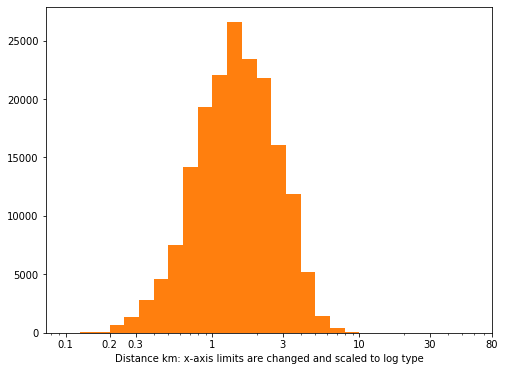

In [38]:
plt.figure(figsize=[8,6])

bins = 10 ** np.arange(-1, 1.8, 0.1)
distance_ticks = [0.1,0.2, 0.3, 1, 3, 10, 30, 80]

plt.hist(data=df_bike, x='distance_km', bins = bins, color=base_color)

plt.xscale('log')
plt.xticks(distance_ticks, distance_ticks)
plt.xlabel('Distance km: x-axis limits are changed and scaled to log type');

The distribution of trip distance is unimodal with spike around 1.5 km. The distribution peak of bike trips in the San Francisco area is around 1.5 km with a duration peak around 8 min.

A box plot will give me an overview of the spread of the majority of the points, with probabilities how long a trip will be.

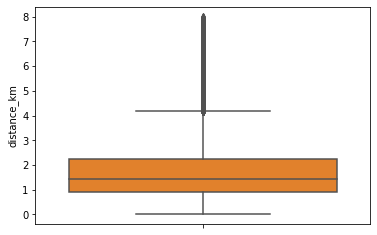

In [39]:
sb.boxplot(data=df_bike.query('distance_km < 8'), y='distance_km', color=base_color);

In [40]:
# I looked up the maximum distance value on Google map and it looks like a feasible trip. 
df_bike.query('distance_km > 68')

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration,start_point,end_point,distance_km,start_point_quadrant,end_point_quadrant
112038,6945,2019-02-12 14:28:44.402,2019-02-12 16:24:30.158,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,300,Palm St at Willow St,37.317298,...,Subscriber,1985-01-01,Female,False,01:55:45.756000,"37 47m 22.6514s N, 122 24m 2.9196s W","37 19m 2.27244s N, 121 53m 5.982s W",69.465977,NE,SW


![Longest Trip](./LongestTrip.png)

#### Number of bike share stations

In [41]:
## number of unique stations
print(df_bike.start_station_id.nunique())

## list of most popular stations
station_counts = df_bike.start_station_id.value_counts()

## select the 20 most popular station_ids
popular_station_ids = df_bike.start_station_id.value_counts()[0:20].index.to_list()
df_bike.query(f'start_station_id == {popular_station_ids}').start_station_name.unique()

330


array(['Montgomery St BART Station (Market St at 2nd St)',
       '4th St at Mission Bay Blvd S',
       'Civic Center/UN Plaza BART Station (Market St at McAllister St)',
       'Bancroft Way at College Ave', 'The Embarcadero at Sansome St',
       'Market St at 10th St',
       'San Francisco Ferry Building (Harry Bridges Plaza)',
       'Beale St at Harrison St', 'Bancroft Way at Telegraph Ave',
       'San Francisco Caltrain (Townsend St at 4th St)',
       'San Francisco Caltrain Station 2  (Townsend St at 4th St)',
       'Powell St BART Station (Market St at 5th St)',
       'Townsend St at 7th St',
       'Embarcadero BART Station (Beale St at Market St)',
       '3rd St at Townsend St', 'Steuart St at Market St',
       'Powell St BART Station (Market St at 4th St)',
       'Howard St at Beale St', 'Berry St at 4th St',
       '2nd St at Townsend St'], dtype=object)

In [45]:
## I would like to plot the stations but have not managed to do so yet.

##find unique combination of two colums (like count_vars but for two columns)
##Could use this to get names and lat longs:
##df_nan_stations.groupby(['start_station_latitude','start_station_longitude']).size().reset_index()


#latitude_list = df_bike.query(f'start_station_id in {popular_station_ids}').start_station_latitude.unique() 
#longitude_list = df_bike.query(f'start_station_id in {popular_station_ids}').start_station_longitude.unique()  
  
#gmap3 = gmplot.GoogleMapPlotter(median_lat, 
                                #median_long, 13)  
## scatter method of map object  
## scatter points on the google map 
#gmap3.scatter( latitude_list, longitude_list, size = 40, marker = False ) 
  
## Plot method Draw a line in 
## between given coordinates 
#gmap3.plot(latitude_list, longitude_list,  
           #'cornflowerblue', edge_width = 2.5) 

#gmap3.heatmap( latitude_list, longitude_list )
  
#gmap3.draw("/Users/cshuttleworth/Projects/Udacity_DAND_Project5_Visuals/pop_stations.png") 


In [46]:
## number of unique stations
print(df_bike.end_station_id.nunique())

## list of most popular stations
station_counts = df_bike.end_station_id.value_counts()

## select the 20 most popular station_ids
popular_station_ids = df_bike.end_station_id.value_counts()[0:20].index.to_list()
df_bike.query(f'end_station_id == {popular_station_ids}').end_station_name.unique()

330


array(['Berry St at 4th St',
       'Powell St BART Station (Market St at 4th St)',
       'San Francisco Ferry Building (Harry Bridges Plaza)',
       '2nd St at Townsend St', '4th St at Mission Bay Blvd S',
       'Market St at 10th St',
       'San Francisco Caltrain Station 2  (Townsend St at 4th St)',
       'Montgomery St BART Station (Market St at 2nd St)',
       'Beale St at Harrison St', 'Steuart St at Market St',
       'Bancroft Way at Telegraph Ave',
       'Embarcadero BART Station (Beale St at Market St)',
       'The Embarcadero at Sansome St',
       'Powell St BART Station (Market St at 5th St)',
       'San Francisco Caltrain (Townsend St at 4th St)',
       'Civic Center/UN Plaza BART Station (Market St at McAllister St)',
       '3rd St at Townsend St', 'Townsend St at 7th St',
       'The Embarcadero at Steuart St', 'Howard St at Beale St'],
      dtype=object)

Out of the 20 most popular bike hiring sites many are around 4th Street and  Market St, which are close to the median point and in what looks like the center of San Francisco.

### Categorical variables: Member Gender, Age, Type

#### **User Gender**

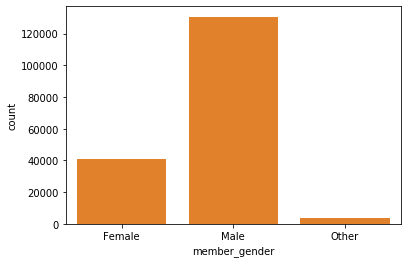

In [47]:
sb.countplot(data=df_bike, x='member_gender', color=base_color);

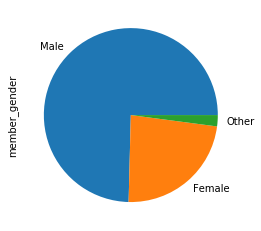

In [48]:
df_bike.member_gender.value_counts().plot.pie(subplots=True);


Interestingly, the majority of bike share users are male. Only a quater of users are female or other. I will look at the difference between the bike trip duration and distance per member_gender.

#### **User Age**

For easier analysis later, I will added an additional column in which the age of the bike share system is calcualted for 2019. It is easier to interpret age data than the date of birth. For the second, one has to do some mental calculations to get the information that is usually wanted - the age.

In [49]:
df_bike['member_age'] = df_bike.apply(lambda row: 2019 - row['member_birth_year'].year, axis=1)

I am keeping the member_age column as float, as it contains NaN values, that I can not convert to int64 and I don't want to set the age to 0. This will make analysis easier, as only datapoints are analysed that contain valid values.

In [50]:
df_bike.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,duration,distance_km,member_age
count,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412.000000,183412,183412.000000,175073.000000
mean,726.078435,138.441569,37.771223,-122.352664,136.102780,37.771427,-122.352250,0 days 00:12:06.577548,1.690555,34.157706
std,1794.389780,111.811012,0.099581,0.117097,111.544544,0.099490,0.116673,0 days 00:29:54.388971,1.097158,9.968536
min,61.000000,0.000000,37.317298,-122.453704,0.000000,37.317298,-122.453704,0 days 00:01:01.081000,0.000000,18.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,0 days 00:05:25.428500,0.909777,27.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,0 days 00:08:34.649500,1.429907,32.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,0 days 00:13:16.317000,2.226169,39.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,0 days 23:44:04.830000,69.465977,92.000000


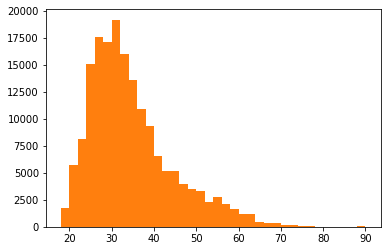

In [51]:
#Plotting a hist chart of the member_age
bins= np.arange(18,92,2)
plt.hist(data=df_bike, x='member_age', bins=bins, color=base_color);

The distribution shows a peak around 32 years.

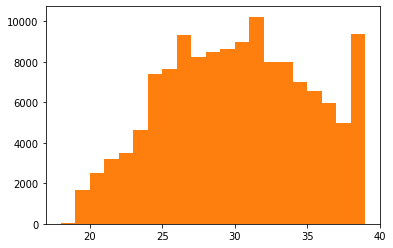

In [52]:
#Looking closer at the data below 40 years:
bins=np.arange(18,40,1)
plt.hist(data=df_bike.query('member_age < 40'), x='member_age', bins=bins, color=base_color);

The distribution of the age of the bike share users below 40 years shows peaks at 27, 32 years old. The age group from 25 to 35 seem to be the predominant group of the bike share users. I will look at the difference in mean distance and length of the trips.

#### **User Type**

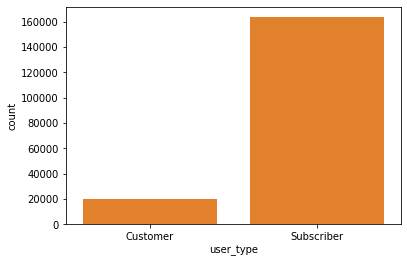

In [53]:
sb.countplot(data=df_bike, x='user_type', color=base_color);

By far the largest amount of users are Subscribers (160 000 as compared to 20 000 customers). That are 89 % of the bike share users. I will look at the difference between these to group and the mean distance and length of the trips taken.

#### **Did user complete their trip with the shared bike or was this just part of the journey**

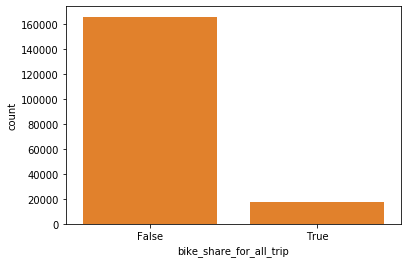

In [54]:
sb.countplot(data=df_bike, x='bike_share_for_all_trip', color=base_color);

Most users of the bike share do not complete their journey on the bike. I will not look into this further.

## Location of the start and end point

The four different quadrant are looked at for the start and end location of the trip: NW, SW, NE, SE of the Greater San Francisco area. I have added another additional column to the table with the start and end station quadrant for the trip.

In [55]:
df_bike.start_station_latitude.max(), df_bike.start_station_longitude.max()
df_bike.start_station_latitude.min(), df_bike.start_station_longitude.min()

(37.3172979, -122.4537044763565)

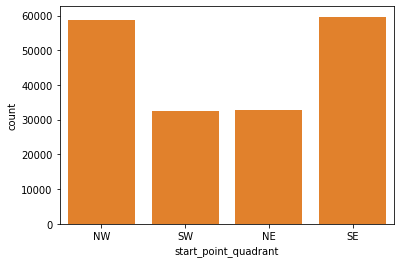

In [56]:
order=['NW', 'SW', 'NE', 'SE']

sb.countplot(data=df_bike, x='start_point_quadrant', order = order, color = base_color);

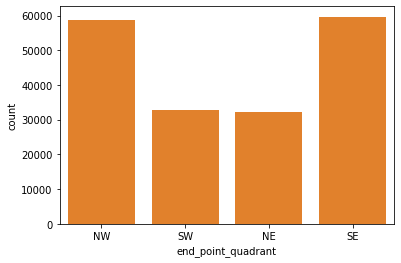

In [57]:
sb.countplot(data=df_bike, x='end_point_quadrant', order = order, color = base_color);

In [58]:
start_and_end_diff = df_bike.loc[df_bike.start_point_quadrant != df_bike.end_point_quadrant].start_time.count()
start_and_end_same = df_bike.loc[df_bike.start_point_quadrant == df_bike.end_point_quadrant].start_time.count()

print(f'Journey that start and end in different quadrants: {start_and_end_diff}')
print(f'Journey that start and end in different quadrants: {start_and_end_same}')

Journey that start and end in different quadrants: 80811
Journey that start and end in different quadrants: 102601


Interestingly the NW ( area has as large a number of bike rides as the SE. The SE is a very large area with many different towns.

In [59]:
plt.figure(figsize=[12,8])
df_bike['start_end_quad'] = df_bike.start_point_quadrant + df_bike.end_point_quadrant

df_bike['start_end_quad'].value_counts()

NWNW    43740
SESE    36248
SWSW    12602
NESE    11685
SENE    11655
NENE    10011
SWSE     7887
SESW     7818
NWSW     6320
SWNW     6304
NESW     6152
SWNE     5701
NENW     4832
NWNE     4743
SENW     3905
NWSE     3809
Name: start_end_quad, dtype: int64

<Figure size 864x576 with 0 Axes>

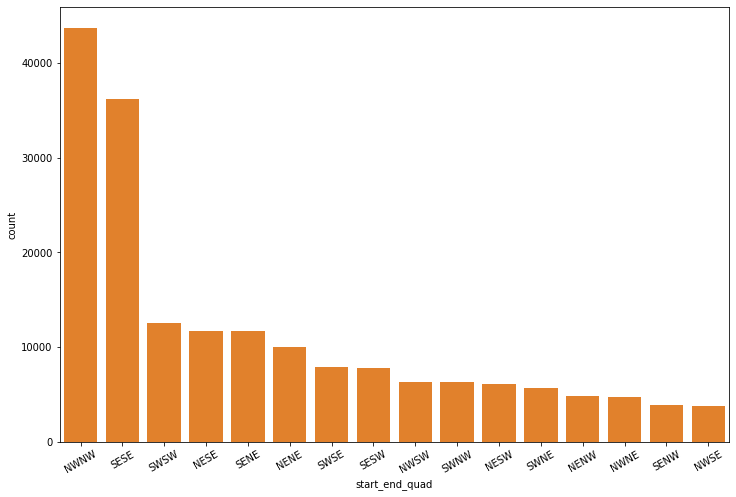

In [60]:
order = df_bike['start_end_quad'].value_counts().index

plt.figure(figsize=[12,8])
sb.countplot(data= df_bike, x='start_end_quad', order =order,color=base_color)
plt.xticks(rotation=30);

Most journey start and end in the NW of the San Franciso Bay area, in the city center of San Francisco Bay. SE coming second and both have a much higher count than other areas.

In [61]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   duration_sec             183412 non-null  int64          
 1   start_time               183412 non-null  datetime64[ns] 
 2   end_time                 183412 non-null  datetime64[ns] 
 3   start_station_id         183412 non-null  int64          
 4   start_station_name       183215 non-null  object         
 5   start_station_latitude   183412 non-null  float64        
 6   start_station_longitude  183412 non-null  float64        
 7   end_station_id           183412 non-null  int64          
 8   end_station_name         183215 non-null  object         
 9   end_station_latitude     183412 non-null  float64        
 10  end_station_longitude    183412 non-null  float64        
 11  bike_id                  183412 non-null  object         
 12  us

## Day of the week

The day of the week may also impact the duration and distance of the trips undertaken. I added a column - weekday for easier analysis.

In [62]:
## Monday = 0, Sunday = 6
df_bike['weekday'] = df_bike.start_time.dt.weekday

df_bike['weekday'].replace({0:'MON', 1:'TUE', 2:'WED', 3:'THU', 4:'FRI', 5:'SAT', 6:'SUN'}, inplace=True)

weekday_order = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

weekday_cat = pd.api.types.CategoricalDtype(ordered=True, categories = weekday_order)
df_bike['weekday'] = df_bike['weekday'].astype(weekday_cat)

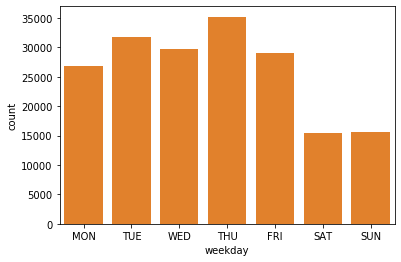

In [63]:
day_order = ['MON','TUE','WED','THU','FRI','SAT','SUN']
sb.countplot(data=df_bike, x='weekday', color=base_color, order =  day_order);

It looks like most trips take place during the week. I will investigate if there is a difference in trip lenght and distance between the weekdays and weekends. As I expect more leisure trips on the weekend (maybe longer) and mainly commuter trips during the week (possibly shorter).

## Hour of the day

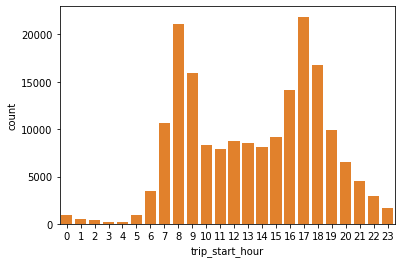

In [64]:
df_bike['trip_start_hour'] = df_bike.start_time.dt.hour
df_bike.head()
sb.countplot(data=df_bike, x='trip_start_hour', color=base_color);

The hourly plot of the bike share usage shows very clearly that there is a bimodal distribution around the two main commuting times, 8 o clock in the morning and 17 o clock in the evening. Further investigation in differences in trip duration will be interesting. Commuter and leisure cyclists I expect to behave quite differently. 

## Bike ID

In [65]:
often_used_bikes = df_bike.bike_id.value_counts()
often_used_bikes

4794    191
4814    176
5014    174
4422    174
5145    173
       ... 
3585      1
653       1
1011      1
2089      1
1960      1
Name: bike_id, Length: 4646, dtype: int64

This information could be used for servicing the bikes or swapping them around, to keep the bicylces in good condition. I will not use bike ID for any further investigation.

# Bivariate Exploration

## The link between trip length and distance

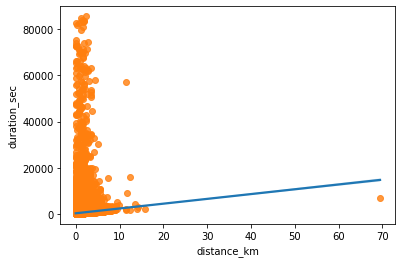

In [66]:
sb.regplot(data=df_bike, x='distance_km', y='duration_sec', color=base_color, line_kws = {'color':line_color});

Since the outlier of 70 km trip is influencing the data so much, I will remove this to see the regression better in the next plot.

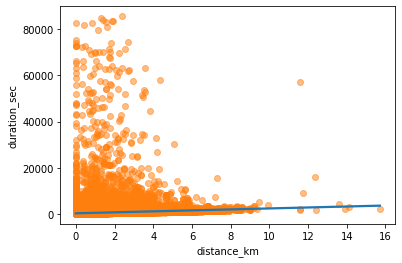

In [67]:
sb.regplot(data=df_bike.query('distance_km < 60'), x='distance_km', y='duration_sec', color = base_color, line_kws = {'color':line_color},scatter_kws = {'alpha': 0.5});

Most trips fall below It is difficult to see but it looks like most of the trips have a linear relationship between duration and distance. I will try and plot a random subset of 50 000 points and a subset of data with shorter distance < 5 km and shorter duration < 800 sec. 

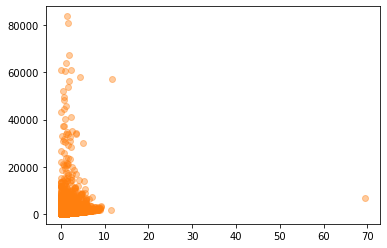

In [68]:
df_bike_sub1 = df_bike.sample(n=50000, replace=False)
plt.scatter(data=df_bike_sub1, x='distance_km', y='duration_sec', color=base_color, alpha=0.4);

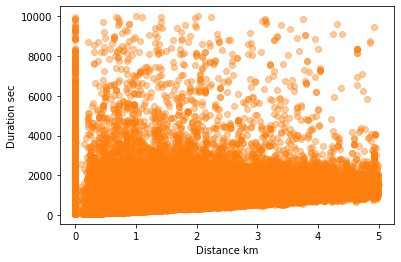

In [69]:
plt.scatter(data=df_bike.query('distance_km < 5 and duration_sec < 10000'), x='distance_km', y='duration_sec', alpha=0.4, color=base_color)
plt.xlabel('Distance km')
plt.ylabel('Duration sec');

In both plots of subset data there is an obvious subset of data that were round trips. Trips, where the starting and ending station was the same. The distance is plotted as 0 but the duration depending on the trip length. Furthermore, the main bulk of trips are found around an average speed for a given distance.

There is also a clear cut off at the lower end of the duration, as there is a minimum duration necessary to get between two points, the longer the distance the larger the minimum duration needed for the trip. From this I can calculate the maximum speeds reached cycling 1 km etc. in the San Francisco Bay area or the min time needed between two points.

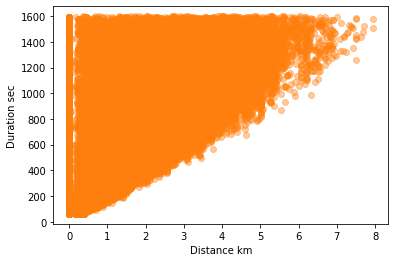

In [70]:
plt.scatter(data=df_bike.query('distance_km < 10 and duration_sec < 1600'), x='distance_km', y='duration_sec', alpha=0.4,color=base_color)
plt.xlabel('Distance km')
plt.ylabel('Duration sec');

#### **Find regression between distance and duration**

Find the linear regression equation between distance and duration for non-round trips and without outlier.

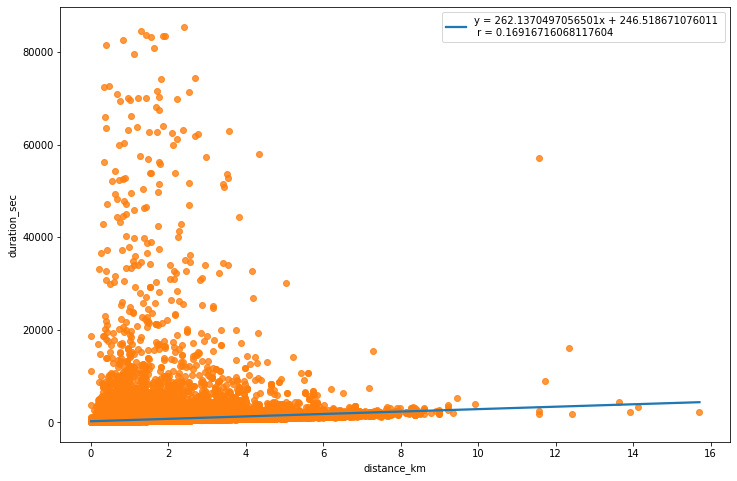

In [71]:
from scipy import stats

df_bike_sub3 = df_bike.query('distance_km != 0 and distance_km < 60')

plt.figure(figsize=[12,8])
line_color = sb.color_palette()[0]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df_bike_sub3['distance_km'],df_bike_sub3['duration_sec'])

# use line_kws to set line label for legend

ax = sb.regplot(data=df_bike_sub3, x="distance_km", y="duration_sec", color=base_color, line_kws = {'color':line_color, 'label':f"y = {slope}x + {intercept} \n r = {r_value}"} )

# plot legend
ax.legend()

plt.show()


The plot shows, that even though there are many points at lower distances that show higher diversity of trip duration, probably due to trip interruptions. The regression equation can be used to calculated how long a trip may last on average, if both the start and end points of the trip are know. This works especially well, above a distance of 4 km. I can also and predict an average duration for a specific distance by calculating an predicted speed using the regression equation above.

Calculate predicted duration for 1 km:

y = 262*1 + 246.5
y = 508.5 sec 

It takes a bike share user a predicted 8.46 min for 1 km.

8.46 min per 1 km  equates to a speed of 7 km/h.

The predicted average minimum speed by users of the car sharing service is 7 km/h. This may be useful to estimate the duration of a bike hire if both the start and end stations of the trip are defined by the user before the hire. It may also be interesting to find out if the subset of data, which looks at bike_share for all trip shows a higher correlation.

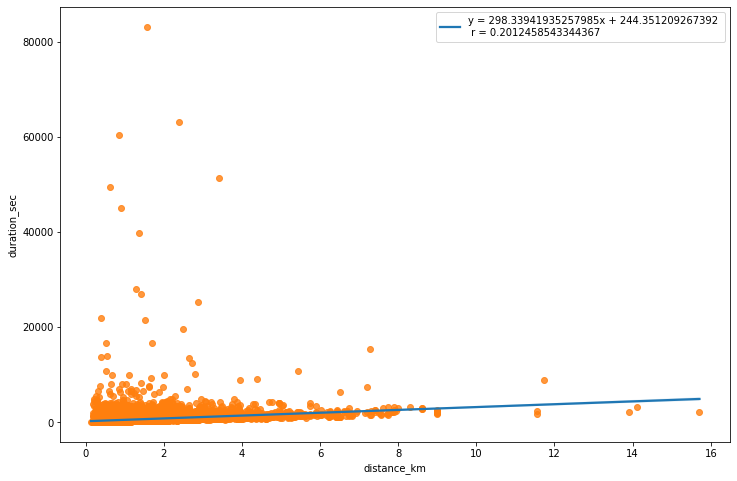

In [72]:
df_bike_sub4 = df_bike.query('bike_share_for_all_trip == True and distance_km != 0')

plt.figure(figsize=[12,8])
line_color = sb.color_palette()[0]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df_bike_sub4['distance_km'],df_bike_sub4['duration_sec'])

# use line_kws to set line label for legend

ax = sb.regplot(data=df_bike_sub4, x="distance_km", y="duration_sec", color=base_color, line_kws = {'color':line_color, 'label':f"y = {slope}x + {intercept} \n r = {r_value}"} )

# plot legend
ax.legend()

plt.show()



The correlation is slightly stronger but there are still many outliers especially at low distances, where users leave the bike at stations close to the start station after a longer almost round trip. The speed calculated from this regression equation is slightly slower at 6.6 km/h.

## Relationship between Duration and User Gender

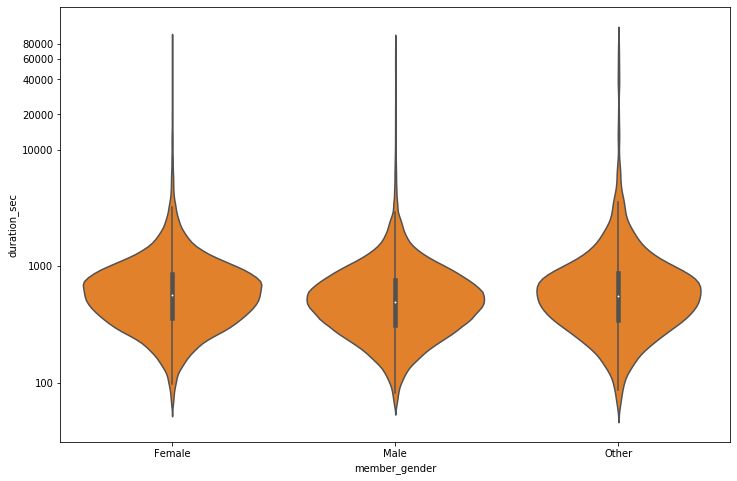

In [73]:
plt.figure(figsize=[12,8])

y_duration_ticks = [100,1000, 10000, 20000, 40000, 60000, 80000]
log_duration_sec = np.log10(df_bike.duration_sec)

sb.violinplot(data=df_bike, x='member_gender', y=log_duration_sec, color=base_color)
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [74]:
df_bike.groupby('member_gender').duration_sec.mean()/60

member_gender
Female    12.984506
Male      11.210651
Other     16.608589
Name: duration_sec, dtype: float64

These distributions look very similar for each of the member gender types. I will not look further to predict trip duraiton with user gender data.

## Relationship between Duration and User Age

In [75]:
df_bike.member_age.describe()

count    175073.000000
mean         34.157706
std           9.968536
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max          92.000000
Name: member_age, dtype: float64

In [76]:
#plt.figure(figsize=[12,20])

age_bins = [18,25,35,45,55, 65,100]
age_labels = ['18 - 24', '25 - 34', '35 - 44', '45 - 54', '55 - 64', 'over 64']

df_bike['age_group'] = pd.cut(df_bike.member_age,age_bins, labels = age_labels, include_lowest=True)


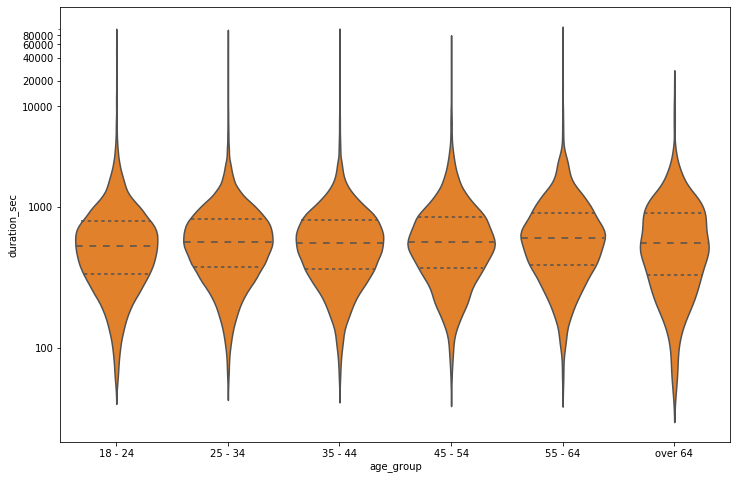

In [77]:
plt.figure(figsize=[12,8])
sb.violinplot(data=df_bike, x='age_group', y=log_duration_sec, color=base_color, inner='quartiles')
plt.yscale('log')
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [78]:
print(f'Average trip duration (min):\n{df_bike.groupby("age_group").duration_sec.mean()/60}')

Average trip duration (min):
age_group
18 - 24    11.416675
25 - 34    11.750325
35 - 44    11.567890
45 - 54    12.261593
55 - 64    12.707322
over 64    12.047418
Name: duration_sec, dtype: float64


There is no great difference between the different age groups in regards to mean bike ride duration. Over the age of 54 the bike rides are spread out a little more. The mean increases but the distribution itself becomes wider. Over the age of 64 and between the ages of 18 and 24, the mean duration is shorter. Distance may show more difference between the age groups.

In [79]:
log_distance_km = np.log10(df_bike.query('distance_km > 0').distance_km)

age_group
18 - 24    1.504186
25 - 34    1.754910
35 - 44    1.710216
45 - 54    1.676751
55 - 64    1.666255
over 64    1.480858
Name: distance_km, dtype: float64


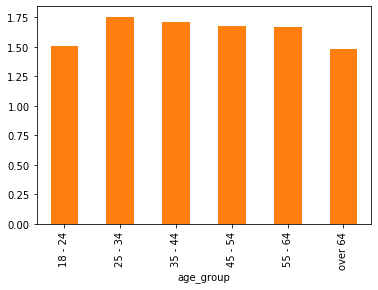

In [80]:
#compute counts

means = df_bike.groupby('age_group').mean().distance_km

means.plot(kind='bar', color=base_color);
print(means)


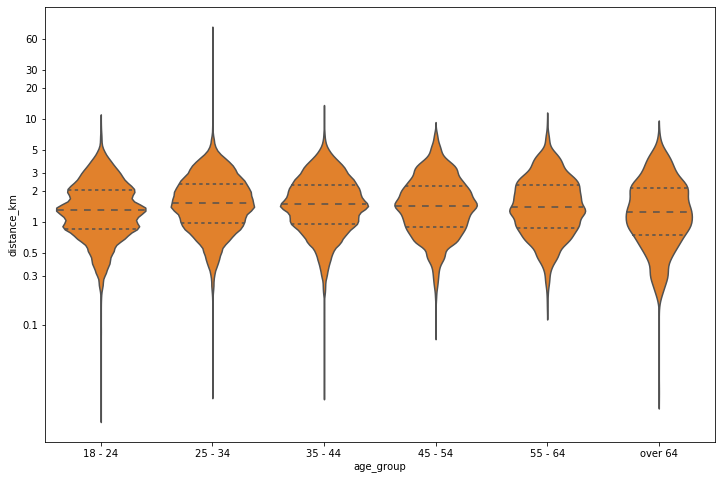

In [81]:
plt.figure(figsize=[12,8]) 
y_distance_ticks = [0.1,0.3,0.5,1,2,3,5,10,20,30,60]
sb.violinplot(data=df_bike.query('distance_km > 0'), x='age_group', y=log_distance_km, color=base_color, inner='quartiles')
plt.yticks(np.log10(y_distance_ticks), y_distance_ticks);

There is again a slight difference between the age groups in average distance. Younger riders (18-24) and older riders (over 64) tend to ride shorter distances, compared to the 34 - 54 age group. But the difference in distance and time are not great enough to use this variable to predict usage differences between age groups.

## Customer Type

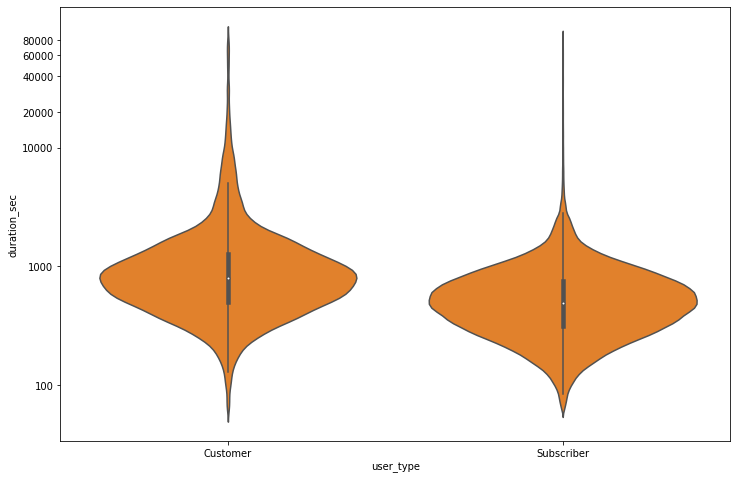

In [82]:
plt.figure(figsize=[12,8])

sb.violinplot(data=df_bike, x='user_type', y=log_duration_sec, color=base_color);

plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

This looks interesting. There is a difference in the mean trip duration and distribution between the customer and subscriber group. Subscribers take generally trips that are less long than as long as customers. The distribution of the subcribers trips are also narrower with a spike around 11 min.

In [83]:
df_bike.groupby('user_type').duration_sec.mean()/60

user_type
Customer      23.874417
Subscriber    10.671061
Name: duration_sec, dtype: float64

## Start and End quartile

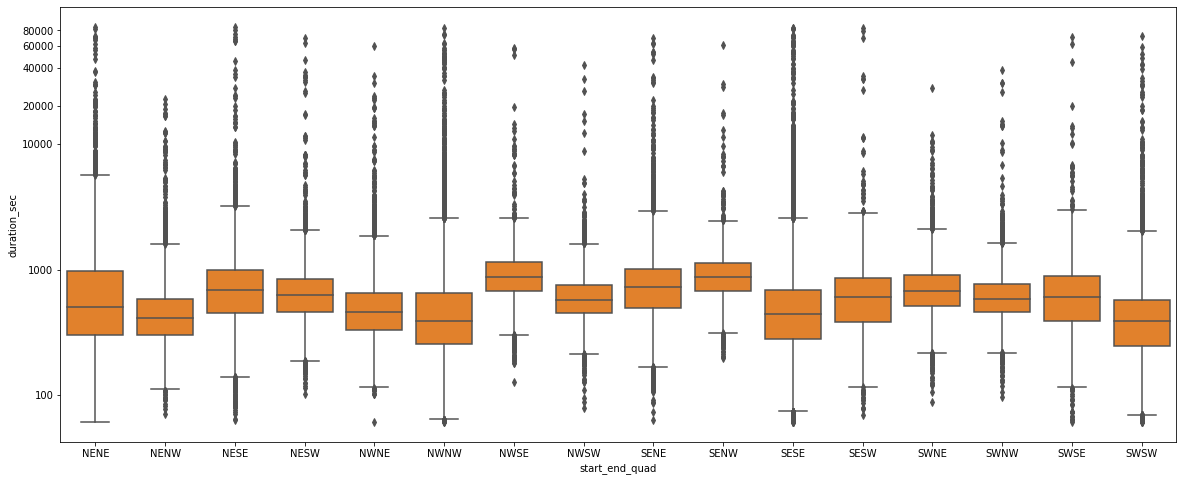

In [84]:
plt.figure(figsize=[20,8])

quartile_start_end_order = ['NENE','NENW', 'NESE', 'NESW', 'NWNE', 'NWNW', 'NWSE', 'NWSW','SENE', 'SENW', 'SESE', 'SESW', 'SWNE', 'SWNW','SWSE', 'SWSW']

sb.boxplot(data=df_bike, x = 'start_end_quad', y = log_duration_sec, order = quartile_start_end_order, color = base_color);
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [85]:
df_bike.groupby('start_end_quad').duration_sec.mean()/60

start_end_quad
NENE    17.487487
NENW     9.957140
NESE    14.645678
NESW    13.414749
NWNE    11.866227
NWNW    10.200534
NWSE    17.485311
NWSW    11.009539
SENE    15.102946
SENW    16.640081
SESE    11.296364
SESW    11.970547
SWNE    13.084643
SWNW    11.449215
SWSE    11.964427
SWSW     9.431225
Name: duration_sec, dtype: float64

There is quite a varied distribution of means considering the different areas. I will have to interpret this together with a map of the quartiles and plotted station. More geographical information is needed for further investigation. This is above my pay grade at the moment.

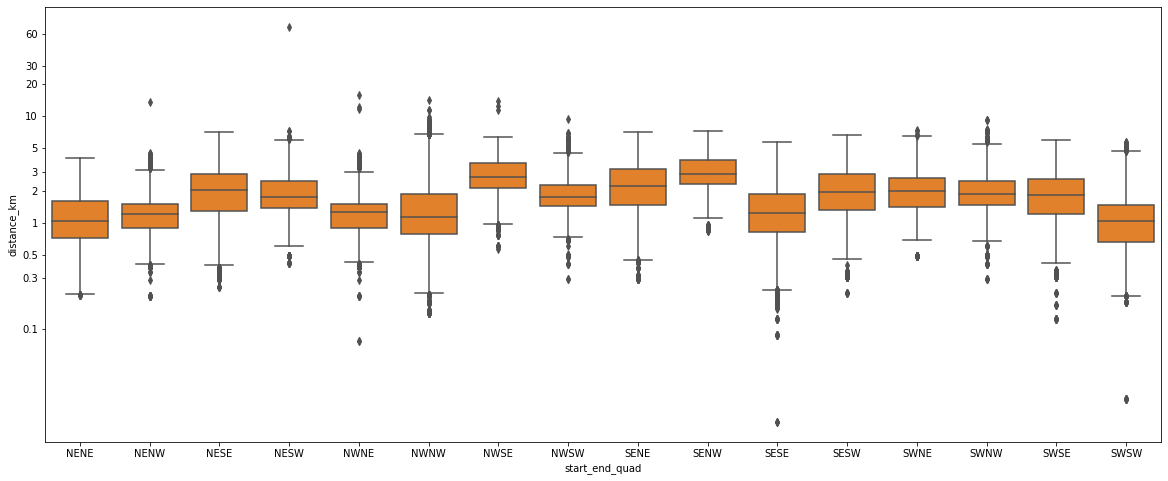

In [86]:
plt.figure(figsize=[20,8])

sb.boxplot(data=df_bike, x = 'start_end_quad', y = log_distance_km, order = quartile_start_end_order, color = base_color);
plt.yticks(np.log10(y_distance_ticks), y_distance_ticks);

The average distance of the trips in the different quadrant looks like they are directly related to the average length of the trips in the different quadrants. I would need to know San Francisco a lot better to see any data points of interest.

In [87]:
df_bike.groupby('start_end_quad').distance_km.mean()

start_end_quad
NENE    1.109033
NENW    1.277153
NESE    2.170415
NESW    2.020314
NWNE    1.290407
NWNW    1.462630
NWSE    2.887613
NWSW    1.959584
SENE    2.401600
SENW    3.102506
SESE    1.390809
SESW    2.137747
SWNE    2.138528
SWNW    2.045586
SWSE    1.968089
SWSW    1.085738
Name: distance_km, dtype: float64

Looking at just starting quadrant. Can we tell a difference in mean trip duration, depending on where the journey started?

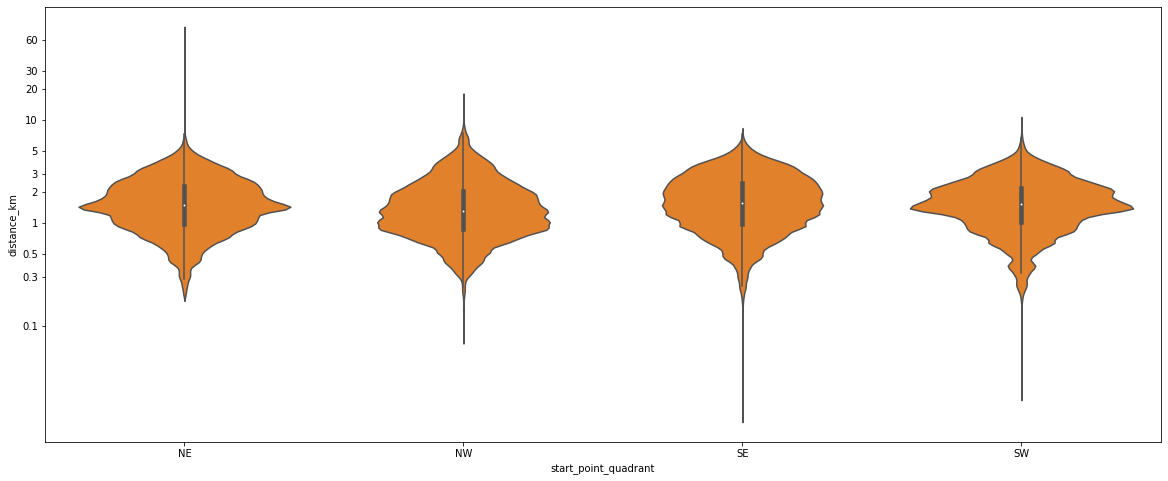

In [88]:
plt.figure(figsize=[20,8])

quartile_order = ['NE', 'NW', 'SE', 'SW']

sb.violinplot(data=df_bike, x = 'start_point_quadrant', y = log_distance_km, order = quartile_order, color = base_color);
plt.yticks(np.log10(y_distance_ticks), y_distance_ticks);

In [89]:
df_bike.groupby('start_point_quadrant').distance_km.mean()

start_point_quadrant
NE    1.684945
NW    1.594883
SE    1.798425
SW    1.670829
Name: distance_km, dtype: float64

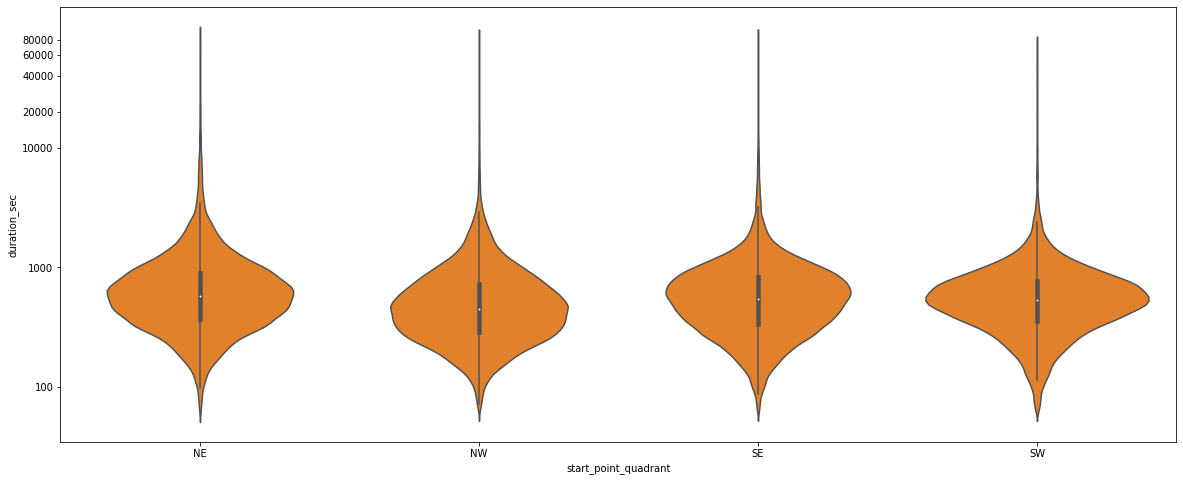

In [90]:
plt.figure(figsize=[20,8])

quartile_order = ['NE', 'NW', 'SE', 'SW']

sb.violinplot(data=df_bike, x = 'start_point_quadrant', y = log_duration_sec, order = quartile_order, color = base_color);
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [91]:
df_bike.groupby('start_point_quadrant').duration_sec.mean()/60

start_point_quadrant
NE    14.591261
NW    10.895972
SE    12.478796
SW    11.078572
Name: duration_sec, dtype: float64

The North East seems to have the longest average trip duration, almost 4 min longer than in the Nort West with the shortest average trip duration of 10.8. Trips in the South West are less wide spread with a larger peak around the mean. There may be similar types of journey. Maybe I can find an interesting relationship between user_type and start_point_quadrant and days of the week and start point quadrant.

## Days of the week

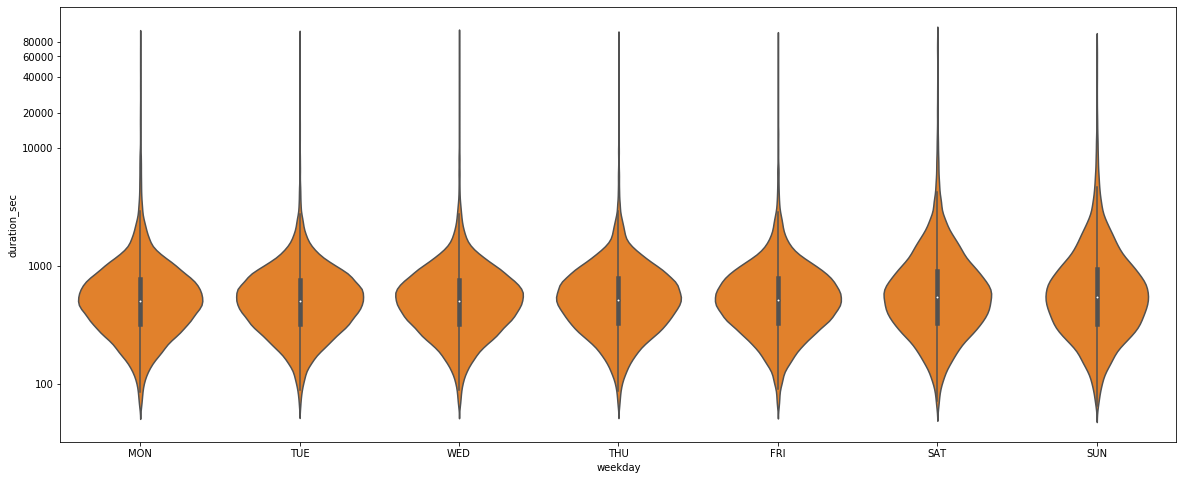

In [92]:
plt.figure(figsize=[20,8])

sb.violinplot(data=df_bike, x='weekday', y=log_duration_sec, color=base_color)
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [93]:
df_bike.groupby('weekday').duration_sec.mean()/60

weekday
MON    11.885994
TUE    11.055093
WED    11.227853
THU    11.650683
FRI    11.596585
SAT    15.044367
SUN    15.329101
Name: duration_sec, dtype: float64

On Saturday and Sunday the average trip on the bike is quite a bit longer - 15 min as compared to 11 min during the week. The spread of the trip duration is also wider on the weekend. This is interesting as it indicates as different group of users and usage. Together with the information that there are fewer trips on the weekend, these groups are behaving differently. 4 min is not a large difference but enough to take notice, as the average trip duration is 8 min.

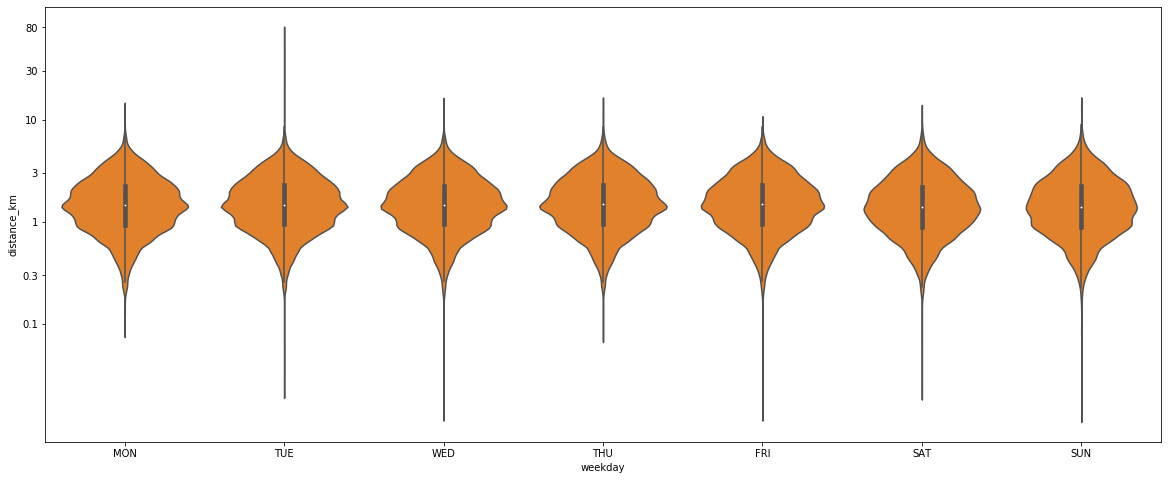

In [94]:
plt.figure(figsize=[20,8])

yticks = [0.1,0.3,1,3,10,30,80]

sb.violinplot(data=df_bike.query('distance_km > 0 '), x='weekday', y=log_distance_km, color=base_color)
plt.yticks(np.log10(yticks), yticks);

In [95]:
df_bike.groupby('weekday').distance_km.mean()

weekday
MON    1.672970
TUE    1.711914
WED    1.698921
THU    1.724060
FRI    1.721610
SAT    1.608512
SUN    1.608698
Name: distance_km, dtype: float64

Interestingly, there is not much difference in the average journey trip on the weekend to the weekdays. I will have to probably look at the round trips to find a difference there. 

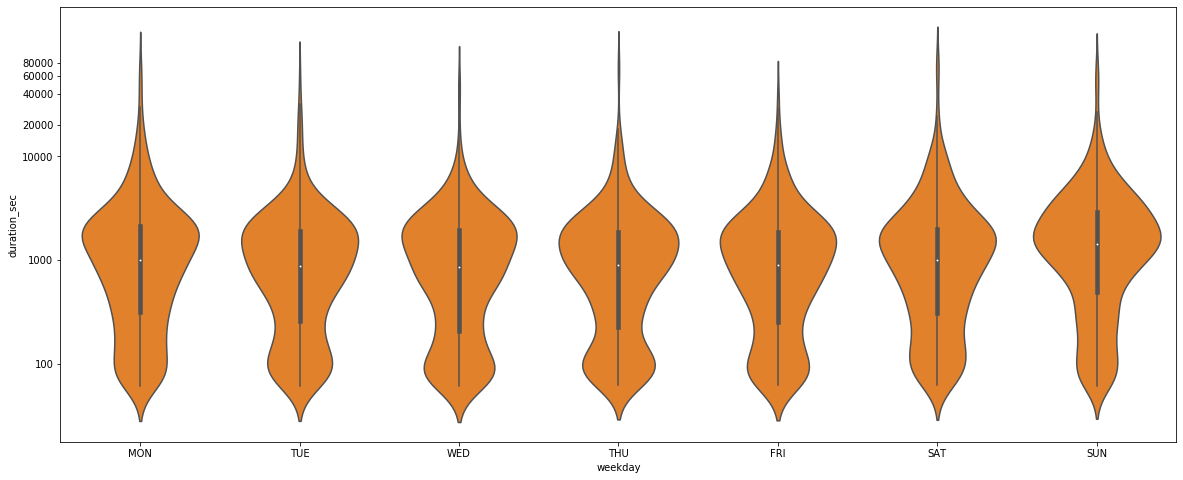

In [96]:
plt.figure(figsize=[20,8])

round_trips = df_bike.query('distance_km == 0')
log_duration_round_trips = np.log10(df_bike.query('distance_km == 0').duration_sec)

sb.violinplot(data=round_trips, x='weekday', y=log_duration_round_trips, color=base_color)
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [97]:
round_trips.groupby('weekday').mean().duration_sec/60

weekday
MON    36.455469
TUE    27.247436
WED    25.244420
THU    27.298174
FRI    26.698603
SAT    37.225621
SUN    43.202679
Name: duration_sec, dtype: float64

There are three interesting observations: 
1. Roundtrips are on average longer than trips to a different destination
2. Weekend round trips are longer than round trips during the week
3. Roundtrips are bimodal. One mode is around 1 - 2 min and another around 30 min. The first user group looks like they are not taking the bike for a ride. I suspect it takes a minute to take the bike away and park it again. They users may start the process of hiring it and then decide against it. Maybe there is a problem with the bike. The second user group rides the bike - most likely for leisure.

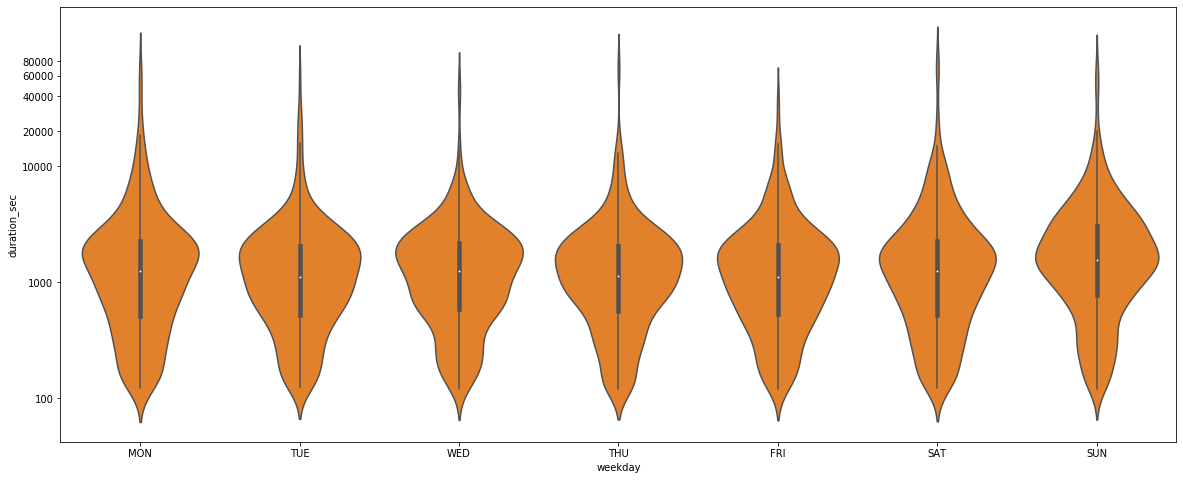

In [98]:
plt.figure(figsize=[20,8])

round_trips_taken = df_bike.query('distance_km == 0 and duration_sec > 120')
log_duration_round_trips_taken = np.log10(df_bike.query('distance_km == 0 and duration_sec > 120').duration_sec)

sb.violinplot(data=round_trips_taken, x='weekday', y=log_duration_round_trips_taken, color=base_color)
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [99]:
round_trips_taken.groupby('weekday').mean().duration_sec/60

weekday
MON    41.204379
TUE    32.247917
WED    30.941621
THU    32.938559
FRI    31.573821
SAT    42.274146
SUN    47.649240
Name: duration_sec, dtype: float64

Looking just at the round trips that take longer than 2 min, the average duration of the trips has increased by around 4 - 5 min.

### Trip start hour

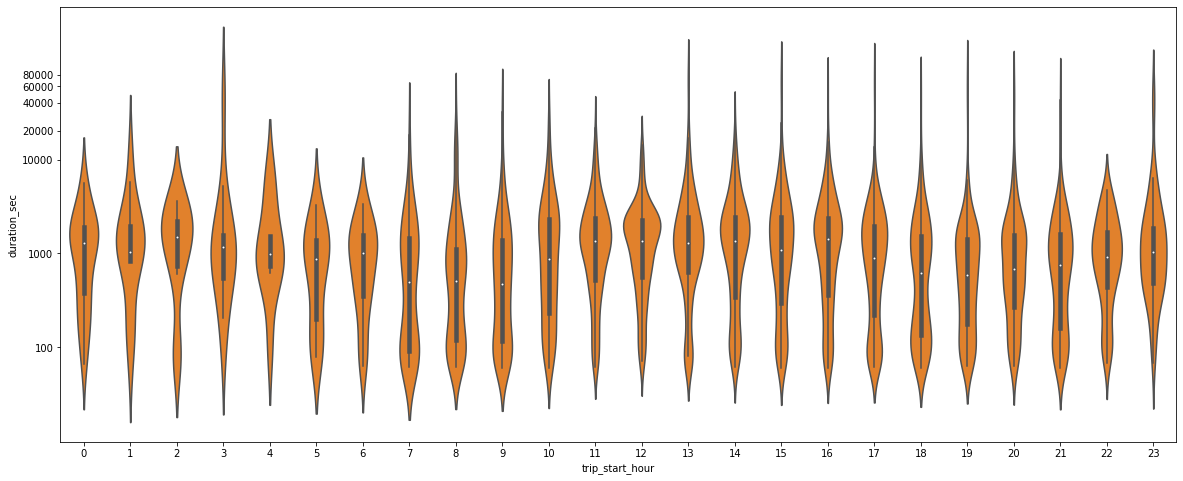

In [100]:
plt.figure(figsize=[20,8])

yticks = [100,1000, 10000, 20000, 40000, 60000, 80000]

sb.violinplot(data=round_trips, x='trip_start_hour', y=log_duration_sec, color=base_color)
#sb.countplot(data=round_trips, x='trip_start_hour', y=log_duration_sec, color = base_color)
plt.yticks(np.log10(yticks), yticks);

In [101]:
mean_dur_rt = round_trips.groupby('trip_start_hour').mean().duration_sec/60

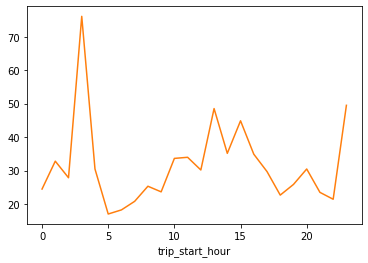

In [102]:
mean_dur_rt.plot(color=base_color);

Here I can see the influence of the trips with less than 2 minutes duration, at 7 - 9 o clock in the morning and 17 - 21 o clock in the evening. This is at rush hours and maybe there are bikes that are not working correctly, which means a rider hires the bike, but returns it when it does not work. Since more bikes are used in the morning, this would also happen more often, as the working bikes are hired and the non-working bikes are left behind, to be almost hired by the next person.

In [103]:
nb_non_working_bikes = df_bike.query('duration_sec < 120 and distance_km == 0').bike_id.nunique()
nb_bikes = df_bike.bike_id.nunique()

print(f'Number of bikes in the bike share system: {nb_bikes}')
print(f'Number of bikes which are possibly not working:{nb_non_working_bikes} ')

non_working_bikes = df_bike.query('duration_sec < 120 and distance_km == 0').bike_id
non_working_bikes = non_working_bikes.to_list()

Number of bikes in the bike share system: 4646
Number of bikes which are possibly not working:468 


(0, 8)

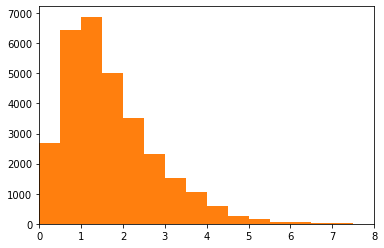

In [104]:
df_bike.query(f'bike_id in {non_working_bikes}').distance_km.mean()
bins=np.arange(0,8,0.5)

plt.hist(data=df_bike.query(f'bike_id in {non_working_bikes}'), x='distance_km', bins=bins, color=base_color);
plt.xlim(0,8)

(0, 2000)

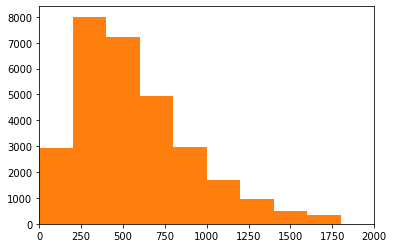

In [105]:
df_bike.query(f'bike_id in {non_working_bikes}').distance_km.mean()
bins = np.arange(0,2000, 200)

plt.hist(data=df_bike.query(f'bike_id in {non_working_bikes}'), x='duration_sec', bins=bins, color=base_color);
plt.xlim(0,2000)

In [106]:
df_non_working_bikes = df_bike.query(f'bike_id in {non_working_bikes}')

mean_dist = df_non_working_bikes.groupby('bike_id').mean().distance_km

mean_dist.to_dict()
[id for id, mean in mean_dist.items() if mean == 0]

['1679']

Having investigated the non-working bikes futher, there is only one bike id that had a distance of 0 in the whole of February, bike_id 1679. This bike was only hired once in the whole month of Feb and then for just over a minute. This could be a faulty bike.

For the other bikes, maybe there is another reason why people return a bike to the original station after 1 - 2 min, or the bikes are serviced quickly and even though there was a problem, the rest of the month the bike worked. 

In [107]:
df_bike.query('bike_id == "1679"').sort_values('start_time')

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,start_point,end_point,distance_km,start_point_quadrant,end_point_quadrant,member_age,start_end_quad,weekday,trip_start_hour,age_group
45774,76,2019-02-22 11:28:03.742,2019-02-22 11:29:20.161,327,5th St at San Salvador St,37.332039,-121.881766,327,5th St at San Salvador St,37.332039,...,"37 19m 55.3393s N, 121 52m 54.3587s W","37 19m 55.3393s N, 121 52m 54.3587s W",0.0,SW,SW,29.0,SWSW,FRI,11,25 - 34


## Bike Share for all trip

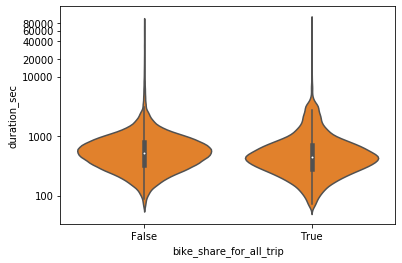

In [108]:
sb.violinplot(data=df_bike, x='bike_share_for_all_trip', y=log_duration_sec, color=base_color)
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [109]:
df_bike.groupby('bike_share_for_all_trip').mean().duration_sec/60

bike_share_for_all_trip
False    12.174238
True     11.403670
Name: duration_sec, dtype: float64

In [110]:
round_trips.groupby('bike_share_for_all_trip').mean().duration_sec/60

bike_share_for_all_trip
False    34.806297
True     24.272575
Name: duration_sec, dtype: float64

The bike share for all trip, does not show a pratical difference between duration mean for the whole dataset. There is however a 10 min difference in mean duration when looking at users who used the bike for the whole trip. 

## Round trip investigation

I have looked at round trip durations earlier. Comparing it per day of the week and trip_start_time.

In [111]:
round_trips.start_time.count()

3880

There are only 3880 trips that are round trips. This is most likely why, this user group shows larger differences between trip durations.

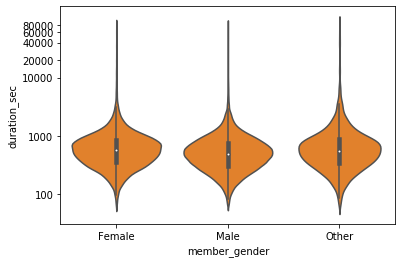

In [112]:
sb.violinplot(data=df_bike, x='member_gender', y=log_duration_sec, color=base_color)
plt.yticks(np.log10(y_duration_ticks), y_duration_ticks);

In [113]:
round_trips.groupby('member_gender').mean().duration_sec/60

member_gender
Female    32.077677
Male      27.967919
Other     49.643528
Name: duration_sec, dtype: float64

There is a larger difference between male and female and other looking at round trips. 5 min between male and female riders and 22 min between male riders and others. There are only 103 data points for other gender preferences. 

In [114]:
round_trips.groupby('member_gender').count().start_time

member_gender
Female     884
Male      2529
Other      103
Name: start_time, dtype: int64

In [115]:
round_trips.groupby('age_group').mean().duration_sec/60

age_group
18 - 24    24.247451
25 - 34    29.536477
35 - 44    35.684308
45 - 54    34.786162
55 - 64    23.614008
over 64    26.788793
Name: duration_sec, dtype: float64

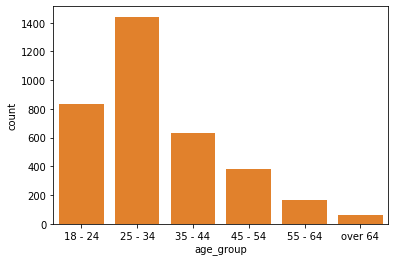

In [116]:
sb.countplot(data=df_bike.query('distance_km == 0'), x = 'age_group',color = base_color);

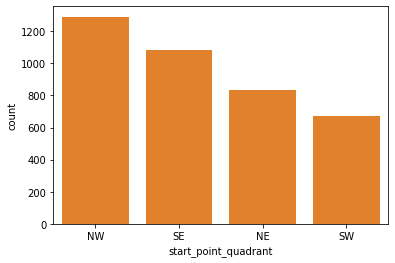

In [117]:
sb.countplot(data=df_bike.query('distance_km == 0'), x = 'start_point_quadrant',color = base_color);

Generally, round trips data is a very small subset of the data. 3880 datapoints out of 180 000. This may be useful for an addition to a bike hire model.

### Interaction between categorical variables: user_type, weekday, trip_start_hour, bike_share_for_all_trip, user_age, start_point_quadrant

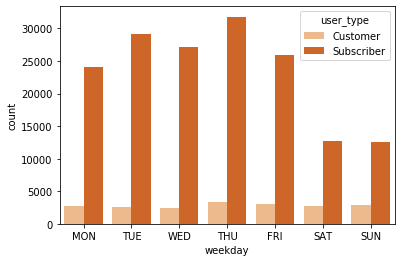

In [118]:
#weekday and user type

sb.countplot(data=df_bike, x='weekday', hue='user_type', palette= 'Oranges')
#sb.countplot(data=fuel_econ_sub, x='VClass', hue='fuelType')

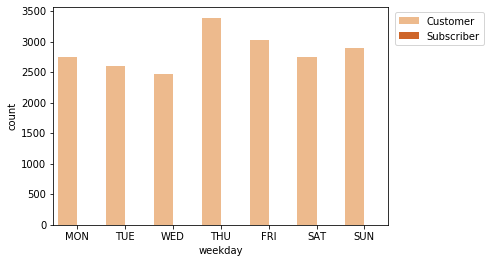

In [119]:
customers = df_bike.query('user_type == "Customer"')
sb.countplot(data=customers, x='weekday', hue='user_type', palette= 'Oranges')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));

Subscribers show different usage between weekdays and weekends, where as customers do not show this difference. This may be caused the commuters being Subcribers and customers being mainly leisuer riders.

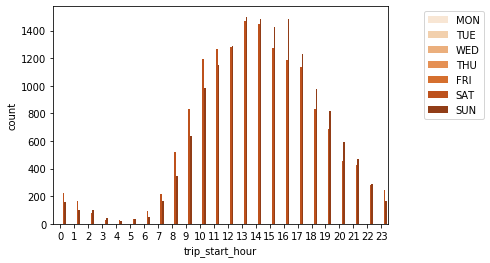

In [120]:
#weekend and trip_start_hour
df_bike_weekend = df_bike.query('weekday in ["SAT", "SUN"]')

sb.countplot(data=df_bike_weekend, x='trip_start_hour', hue='weekday', palette= 'Oranges')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));

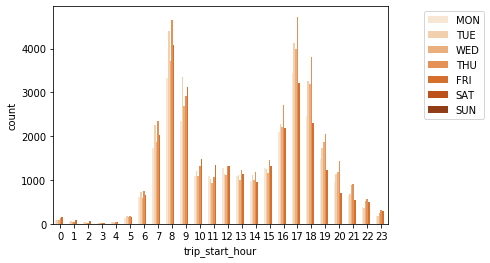

In [121]:
df_bike_weekday = df_bike.query('weekday not in ["SAT", "SUN"]')

sb.countplot(data=df_bike_weekday, x='trip_start_hour', hue='weekday', palette= 'Oranges')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));

The distribution of trip start time is quite difference between the weekend and the week. During the week it follows the overall trend of many trips during rush hours. On the weekend, the trips rise steadily to a peak around lunch time and then fall steadliy to a minimum at 4 o clock in the morning.

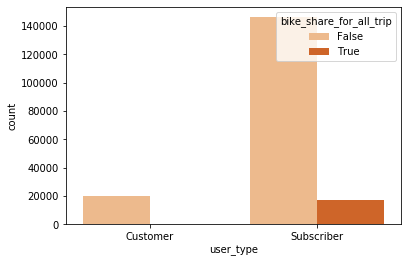

In [122]:
#user_type and bike share for whole trip
sb.countplot(data=df_bike, x='user_type', hue='bike_share_for_all_trip', palette= 'Oranges');

In [123]:
df_bike.groupby(['user_type', 'bike_share_for_all_trip']).count().start_time

user_type   bike_share_for_all_trip
Customer    False                       19868.0
            True                            NaN
Subscriber  False                      146185.0
            True                        17359.0
Name: start_time, dtype: float64

There are no customers for whom the information bike_share_for_all_trip is True. This may be because they do not use the bike for the whole trip or more likely, the information is only available for subscribers.

# Multivariate Exploration

The main variables I want to investigate further are: weekday, trip start hour, user_type, starting_point_quadrant, start and end_point quadrant and  user age. As there were signs that the trip durations vary with these subdivision of this data.

## Duration, day of week and trip start hour

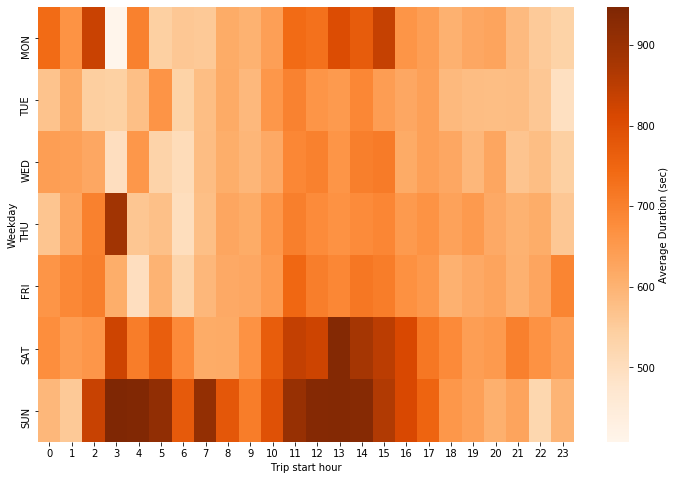

In [124]:
## Duration, Day of week, trip start hour - Looking at trips that lasted less than 3 hours to make the trend clearer.
plt.figure(figsize=[12,8])

df_bike_sub4 = df_bike.query('duration_sec < 10800')
cat_means = df_bike_sub4.groupby(['trip_start_hour', 'weekday']).mean()['duration_sec']
cat_means = cat_means.reset_index(name='dur_avg')  ## turn data series into dataframe
cat_means = cat_means.pivot(index='weekday', columns='trip_start_hour', values='dur_avg')
cat_means

sb.heatmap(cat_means, fmt='.2f', cbar_kws = {'label' : 'Average Duration (sec)'}, cmap='Oranges')
plt.xlabel('Trip start hour')
plt.ylabel('Weekday');

In minutes, the scale show values from 8 min (500 sec) until 15 min (900 sec). There is still a clear trend that trip durations are longer on the weekend and during the weekend there is a peak around the mid of the day on Saturday but more clearly on Sunday. Datapoints before 6 o clock in the morning are few and the values vary quite a bit, because outlier influencing the result. Interestingly, there are also slightly longer trips during monday lunch time. Maybe Monday is a common day off for people working the weekend and it has more leisure trips than other weekdays during the week.

## Duration, customer type and weekday 

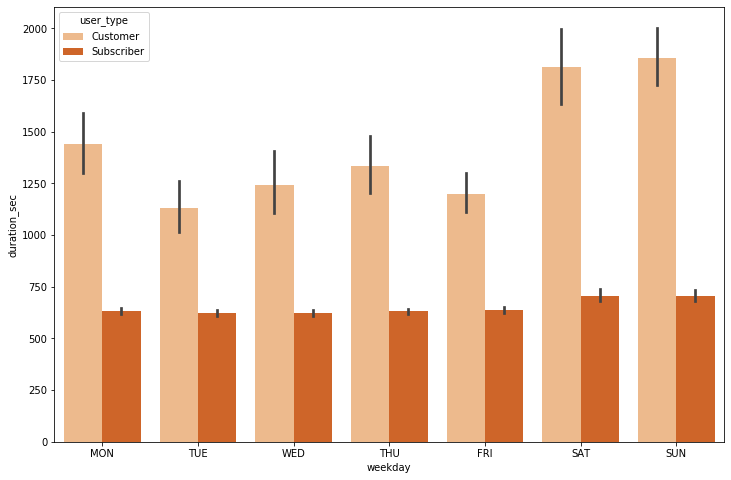

In [125]:
plt.figure(figsize=[12,8])

sb.barplot(data=df_bike, x='weekday', y='duration_sec', hue='user_type', palette= 'Oranges');


The trip length of Subscribers very little during the week and rises slightly on the weekend, but generally the trip length is around 10 min. The customer group shows more variabiliy, Sat, Sun have an average trip duration of 30 min as compared to 20 min during the week. A slight exception is again Monday with and average of 24 min.

## Duration, trip start hour and customer type

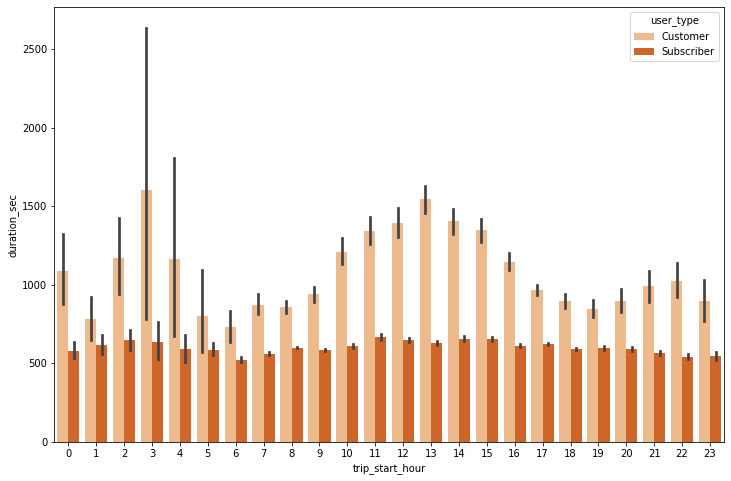

In [126]:
plt.figure(figsize=[12,8])

sb.barplot(data=df_bike.query('duration_sec < 10800'), x='trip_start_hour', y='duration_sec', hue='user_type', palette= 'Oranges');

The subscribers seem to using the and bike for very regular trips at a duration around 10 min. The customers trip length varies with the time of the day, just like weekend riders, with a peak around lunchtime.

## Duration/Distance, weekday, start point quadrant

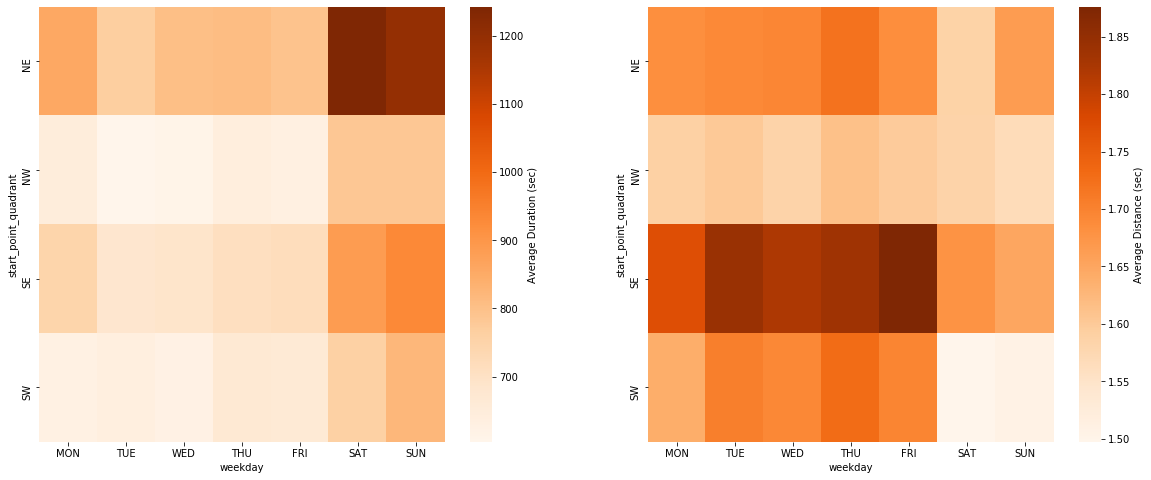

In [127]:
#df_bike_sub7 = df_bike.query('duration_sec < 10800')
plt.figure(figsize=[20,8])
plt.subplot(1,2,1)

cat_means = df_bike.groupby(['start_point_quadrant', 'weekday']).mean()['duration_sec']
cat_means = cat_means.reset_index(name='dur_avg')  ## turn data series into dataframe
cat_means = cat_means.pivot(index='start_point_quadrant', columns='weekday', values='dur_avg')
cat_means

sb.heatmap(cat_means, fmt='.2f', cbar_kws = {'label' : 'Average Duration (sec)'}, cmap='Oranges');

plt.subplot(1,2,2)

cat_means = df_bike.groupby(['start_point_quadrant', 'weekday']).mean()['distance_km']
cat_means = cat_means.reset_index(name='dis_avg')  ## turn data series into dataframe
cat_means = cat_means.pivot(index='start_point_quadrant', columns='weekday', values='dis_avg')
cat_means

sb.heatmap(cat_means, fmt='.2f', cbar_kws = {'label' : 'Average Distance (sec)'}, cmap='Oranges');


This multi variable analysis shows, that trips on the Saturday and Sunday are longer in all quadrants, but most in the NE, with an average that is 5 min longer. 

Looking at the distance that was travelled - the average distance travelled is longer during the week than on the weekend. Maybe on the weekend there are more round trips that take longer but show a short distance or the bike trips are interrupted more often, for shopping etc.

In the SE the average trip duration is less than in the NE in the week but the average distance is higher than the NE in the week. Maybe the bike stations are further apart or the terraine is easier to ride and commuters ride further. 

The low correlation between duration and speed is difficult to interpret without more data of actual trips taken.

<Figure size 2160x576 with 0 Axes>

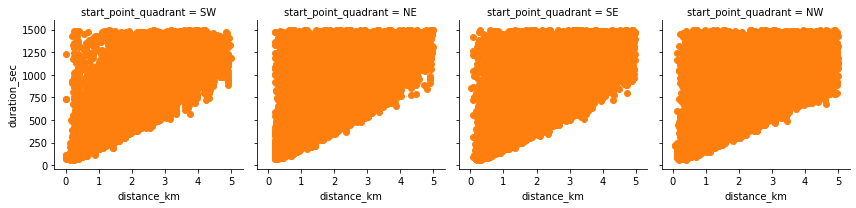

In [128]:
plt.figure(figsize=[30,8])
# Plot Seaborns FacetGrid
g = sb.FacetGrid(data = df_bike.query('distance_km < 5 and distance_km != 0 and duration_sec < 1500'), col='start_point_quadrant', col_wrap=4);
g.map(plt.scatter, 'distance_km', 'duration_sec', color=base_color);

Of all the start quadrants the NE and SE seem to have the most numbers of outliers and least correlated data (see correlation coeffient below) . In the SW quadrant, the correlation between distance and duration of a trip has the highest correlaction but still very low overall. Finding the users with uninterrupted trips would help predict duration based on the distance.

In [129]:
from scipy.stats import pearsonr

for i in quartile_order:
    df_bike_sub = df_bike.query(f'start_point_quadrant == "{i}" and distance_km < 20 and duration_sec < 1500 and distance_km !=0')
    corr, _ = pearsonr(df_bike_sub.distance_km, df_bike_sub.duration_sec)
    print(f'Pearsons correlation for {i}: %.3f' % corr)



Pearsons correlation for NE: 0.743
Pearsons correlation for NW: 0.798
Pearsons correlation for SE: 0.829
Pearsons correlation for SW: 0.789


## Duration/Distance, weekday, start and end quadrant

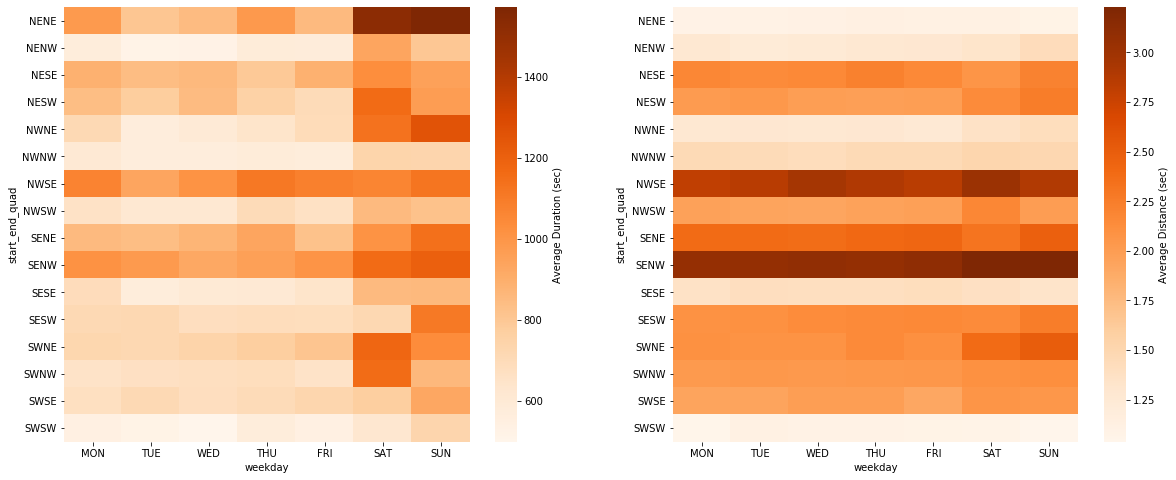

In [130]:
plt.figure(figsize=[20,8])
plt.subplot(1,2,1)

cat_means = df_bike.groupby(['start_end_quad', 'weekday']).mean()['duration_sec']
cat_means = cat_means.reset_index(name='dur_avg')  ## turn data series into dataframe
cat_means = cat_means.pivot(index='start_end_quad', columns='weekday', values='dur_avg')
cat_means

sb.heatmap(cat_means, fmt='.2f', cbar_kws = {'label' : 'Average Duration (sec)'}, cmap='Oranges');

plt.subplot(1,2,2)
cat_means = df_bike.groupby(['start_end_quad', 'weekday']).mean()['distance_km']
cat_means = cat_means.reset_index(name='dis_avg')  ## turn data series into dataframe
cat_means = cat_means.pivot(index='start_end_quad', columns='weekday', values='dis_avg')
cat_means

sb.heatmap(cat_means, fmt='.2f', cbar_kws = {'label' : 'Average Distance (sec)'}, cmap='Oranges');


The trips that take the longest on average during the whole week are trips from the NW to the SE and from the SE to the NW. This would be interesting to investigate with a closer geographical look at where the bike stations are etc. The average distances of bike rides between NW and SE are also longer than the other areas.

Very clear is also the longer trip durations in the NE on the weekends. Maybe this is a popular biking/shopping area in San Francisco. The average distances that customers travel in the NENE quadrant is however only half the distance compared to SENW or NWSE. Maybe riders take breaks from their rides or travel in a circle and come close to the original hiring station again.

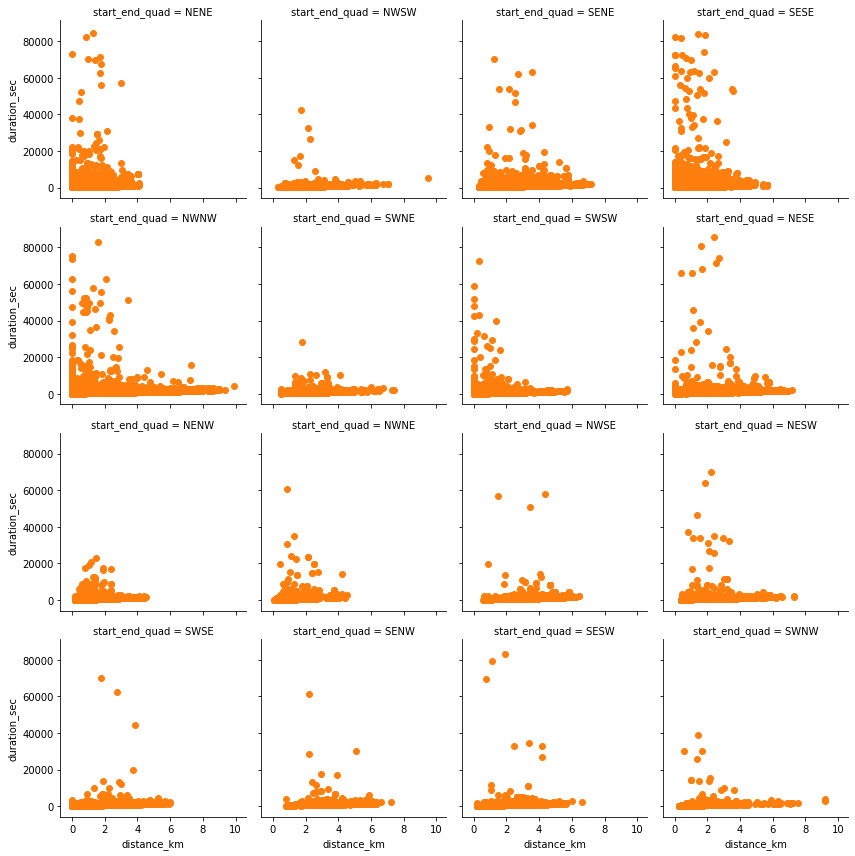

In [131]:
# Plot Seaborns FacetGrid
g = sb.FacetGrid(data = df_bike.query('distance_km < 10'), col= 'start_end_quad', col_wrap=4)
g.map(plt.scatter, 'distance_km', 'duration_sec', color=base_color);

In [132]:
for i in quartile_start_end_order:
    df_bike_sub = df_bike.query(f'start_end_quad == "{i}" and distance_km < 10')
    corr, _ = pearsonr(df_bike_sub.distance_km, df_bike_sub.duration_sec)
    print(f'Pearsons correlation for {i}: %.3f' % corr)


Pearsons correlation for NENE: 0.045
Pearsons correlation for NENW: 0.178
Pearsons correlation for NESE: 0.140
Pearsons correlation for NESW: 0.125
Pearsons correlation for NWNE: 0.156
Pearsons correlation for NWNW: 0.143
Pearsons correlation for NWSE: 0.195
Pearsons correlation for NWSW: 0.233
Pearsons correlation for SENE: 0.182
Pearsons correlation for SENW: 0.192
Pearsons correlation for SESE: 0.061
Pearsons correlation for SESW: 0.166
Pearsons correlation for SWNE: 0.355
Pearsons correlation for SWNW: 0.196
Pearsons correlation for SWSE: 0.245
Pearsons correlation for SWSW: 0.029


Because of many outliers, the correlations are low between distance and duration. Trips from the SW to the NE have the highest correlation and there it will be easiest to predict trip duration from planned distance of the trip. This is useful, if users enter the planned end trip station, when they rent the bike. For most of the areas it will be possible to predict duration of the planned trip quite well, if the outliers are ignored, the correlation is quite strong.

## Duration, Distance, weekday and age_group user group

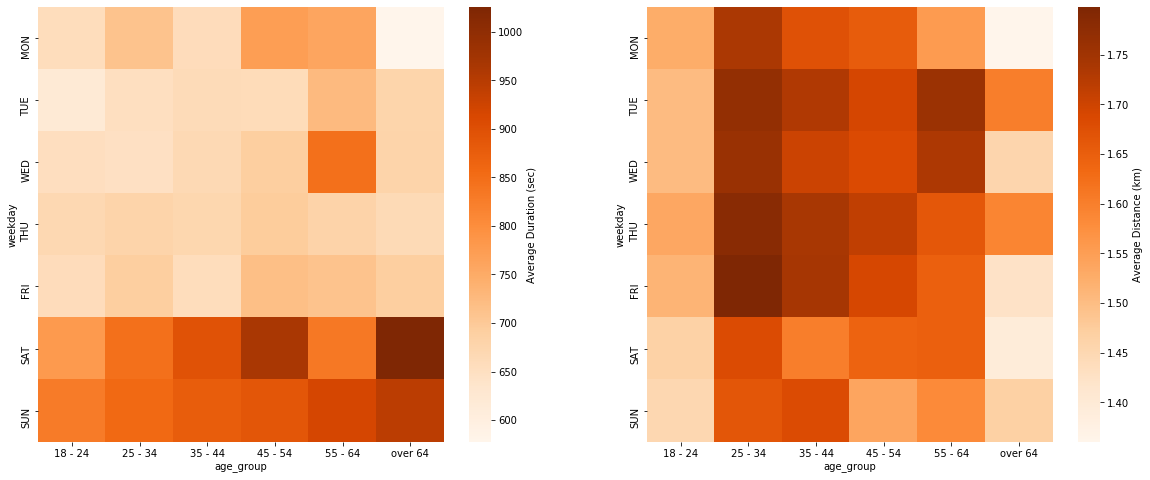

In [133]:
plt.figure(figsize=[20,8])
plt.subplot(1,2,1)

cat_means = df_bike.groupby(['age_group', 'weekday']).mean()['duration_sec']
cat_means = cat_means.reset_index(name='dur_avg')  ## turn data series into dataframe
cat_means = cat_means.pivot(index='weekday', columns='age_group', values='dur_avg')
cat_means

sb.heatmap(cat_means, fmt='.2f', cbar_kws = {'label' : 'Average Duration (sec)'}, cmap='Oranges');

plt.subplot(1,2,2)
cat_means = df_bike.groupby(['age_group', 'weekday']).mean()['distance_km']
cat_means = cat_means.reset_index(name='dis_avg')  ## turn data series into dataframe
cat_means = cat_means.pivot(index='weekday', columns='age_group', values='dis_avg')
cat_means

sb.heatmap(cat_means, fmt='.2f', cbar_kws = {'label' : 'Average Distance (km)'}, cmap='Oranges');

Looking at age group, weekday and average duration of the bike trips, I can see the same picture as in the overall analysis, the trips on the weekend are longer than in the week. Looking at age group as well, there is a trend that older riders have longer average trip durations, especially over 64. The distance of older riders is however shorter, so either the cycle slower, interrupt their trip more often, or cycle more often on round trips or almost round trips.

During the week, the trip duration is on average shorter but compared to the weekend also longer in distance. This may be because these rides are more utilitarian - faster speed between work and home on a route that is well knowsn. Expecially 25 - 34 year olds seem to ride shorter trips over longer distances than other age groups.

## Were there any interesting or surprising interactions between features?

It was generally surprising, how even the trip duration was between all the variables looked at. The large number of trips averaged out many different behaviours. It was difficult to find interesting trends, that influenced the trip duration average more than a few mimutes. When there were trends to be found, they often compared two very different sized audiences. The only real trend showing different user behaviour, was looking at the time analysis of weekday and trip start time. Generally, I think a geographical investigation of the sites and trip duration may be more interesting. 

Apart from the overall anaylsis, I found it interesting to look at a small subset of the data, which I called round trips, as they start and end at the same station_id. Because of the smaller sample, there were some interesting trends, like the bimodality of the data. Diggind further into why people take some very short round trips would be interesting, but for that I would need some more information on the sites and the bikes, maintenance of the bikes and general bike usage in the US.

### Writing clean data set to csv file:

In [134]:
df_bike.to_csv('df_bike_clean.csv')

## Appendix:

https://www.kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python

https://pypi.org/project/geopy/

https://stackoverflow.com/questions/55909305/using-geopy-in-a-dataframe-to-get-distances

https://geopy.readthedocs.io/en/stable/#module-geopy.distance

https://stackoverflow.com/questions/31490816/calculate-datetime-difference-in-years-months-etc-in-a-new-pandas-dataframe-c

https://www.geeksforgeeks.org/python-plotting-google-map-using-gmplot-package/

https://stackoverflow.com/questions/45902739/seaborn-annotate-the-linear-regression-equation